In [82]:
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)
import requests
from bs4 import BeautifulSoup
import re
import geopy # https://github.com/shakasom/geocoding/blob/master/geocoding.ipynb
from geopy.geocoders import Nominatim
import json
import geopy.distance
import numpy as np
import itertools
import shapely.geometry
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import tabula
import datetime as dt

In [2]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 200

In [3]:
# Projected Coordinate System (PCS): how you project onto a 2D plane
epsg_2d = 26717 
# Toronto Police Service Open Data includes geographic location information provided in
# the projected coordinate system NAD 1927 UTM 17N
# https://epsg.io/26717

# Geographic Coordinate System (GCS): how coordinates are represented in a 3D space
# World Geodetic System 1984 (WGS84)
# https://epsg.io/4326
epsg_3d = 4326 

# Import Toronto major crime indicators (MCI)
- About and documentation https://data.torontopolice.on.ca/datasets/TorontoPS::major-crime-indicators-1/about 

- Other crimes:
    - homicide csv https://data.torontopolice.on.ca/datasets/TorontoPS::homicide-asr-rc-tbl-002/explore?location=43.721941%2C-79.371145%2C11.78&showTable=true
    - shootings csv https://data.torontopolice.on.ca/datasets/TorontoPS::shootings-and-firearm-discharges/explore?location=21.919150%2C-39.812750%2C4.69&showTable=true
    - Theft from motor vehicle https://data.torontopolice.on.ca/datasets/TorontoPS::theft-from-motor-vehicle/explore?location=22.246462%2C-39.965802%2C4.69&showTable=true
        - theft over 5,000 is already included in MCI as 'thefy over'
    - bicycle theft https://data.torontopolice.on.ca/datasets/TorontoPS::bicycle-thefts/explore?location=21.520237%2C-39.911850%2C4.53&showTable=true


In [4]:
mci_df = pd.read_csv('../data/raw/Major_Crime_Indicators.csv')
mci_df.drop(columns = ['premises_type', 'x', 'y'], inplace = True)
mci_df['occurrence_date'] = pd.to_datetime(mci_df['occurrence_date'], format='%Y-%m-%d %H:%M:%S')
mci_df

C:\Users\willi\AppData\Local\Temp\ipykernel_36248\630976533.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  mci_df = pd.read_csv('../data/raw/Major_Crime_Indicators.csv')


occurrence_unique_id occurrence_date  occurrence_year occurrence_month  \
0             GO-2015194909      2015-02-02             2015         February   
1             GO-2015194909      2015-02-02             2015         February   
2             GO-2015216532      2015-02-03             2015         February   
3             GO-2015221290      2015-02-07             2015         February   
4             GO-2015227725      2015-02-08             2015         February   
...                     ...             ...              ...              ...   
281687       GO-20192449027      2019-11-19             2019         November   
281688       GO-20192449024      2019-11-20             2019         November   
281689       GO-20192449018      2019-11-26             2019         November   
281690       GO-20192449099      2019-12-13             2019         December   
281691       GO-20192448999      2019-12-13             2019         December   

        occurrence_day  occurrence_dayofyear occurrence_dayofweek  \
0                    2                    33           Monday       
1                    2                    33           Monday       
2                    3                    34           Tuesday      
3                    7                    38           Saturday     
4                    8                    39           Sunday       
...                ...                   ...                  ...   
281687              19                   323           Tuesday      
281688              20                   324           Wednesday    
281689              26                   330           Tuesday      
281690              13                   347           Friday       
281691              13                   347           Friday       

        occurrence_hour      MCI hood_id           neighbourhood  longitude  \
0                    19  Assault       1  West Humber-Clairville -79.606775   
1                    19  Assault       1  West Humber-Clairville -79.606775   
2                     9  Assault       1  West Humber-Clairville -79.595459   
3                     0  Assault       1  West Humber-Clairville -79.622177   
4                     2  Assault       1  West Humber-Clairville -79.604057   
...                 ...      ...     ...                     ...        ...   
281687               15  Robbery     NSA                     NSA -79.786297   
281688               18  Robbery     NSA                     NSA -79.593499   
281689               11  Robbery     NSA                     NSA -79.756417   
281690               14  Robbery     NSA                     NSA -79.658901   
281691               17  Robbery     NSA                     NSA -79.782527   

         latitude  
0       43.733147  
1       43.733147  
2       43.737516  
3       43.726176  
4       43.731845  
...           ...  
281687  43.595291  
281688  43.600526  
281689  43.771014  
281690  43.615117  
281691  43.704650  

[281692 rows x 13 columns]

## drop duplicates

In [5]:
mci_df[mci_df.duplicated(keep=False)].sort_values(by = 'occurrence_unique_id')

occurrence_unique_id occurrence_date  occurrence_year occurrence_month  \
253193       GO-20141150249      1995-01-01                0              NaN   
253190       GO-20141150249      1995-01-01                0              NaN   
148667       GO-20141259762      2013-12-31             2013         December   
148666       GO-20141259762      2013-12-31             2013         December   
96735        GO-20141259834      2014-01-01             2014          January   
...                     ...             ...              ...              ...   
280550        GO-2021999374      2021-05-29             2021              May   
280549        GO-2021999374      2021-05-29             2021              May   
131362        GO-2021999725      2021-05-29             2021              May   
131363        GO-2021999725      2021-05-29             2021              May   
131361        GO-2021999725      2021-05-29             2021              May   

        occurrence_day  occurrence_dayofyear occurrence_dayofweek  \
253193               0                     0                  NaN   
253190               0                     0                  NaN   
148667              31                   365           Tuesday      
148666              31                   365           Tuesday      
96735                1                     1           Wednesday    
...                ...                   ...                  ...   
280550              29                   149           Saturday     
280549              29                   149           Saturday     
131362              29                   149           Saturday     
131363              29                   149           Saturday     
131361              29                   149           Saturday     

        occurrence_hour      MCI hood_id                      neighbourhood  \
253193               12  Assault     131                              Rouge   
253190               12  Assault     131                              Rouge   
148667               23  Assault      77  Waterfront Communities-The Island   
148666               23  Assault      77  Waterfront Communities-The Island   
96735                 0  Assault      55                   Thorncliffe Park   
...                 ...      ...     ...                                ...   
280550               20  Assault     NSA                                NSA   
280549               20  Assault     NSA                                NSA   
131362               21  Assault      74                North St.James Town   
131363               21  Assault      74                North St.James Town   
131361               21  Assault      74                North St.James Town   

        longitude   latitude  
253193 -79.230100  43.823032  
253190 -79.230100  43.823032  
148667 -79.390756  43.649131  
148666 -79.390756  43.649131  
96735  -79.346588  43.703212  
...           ...        ...  
280550   0.000000   0.000000  
280549   0.000000   0.000000  
131362 -79.373738  43.667295  
131363 -79.373738  43.667295  
131361 -79.373738  43.667295  

[58058 rows x 13 columns]

In [6]:
mci_df.drop_duplicates(keep = 'first', inplace = True)

In [7]:
mci_df.shape

(249033, 13)

In [8]:
mci_df.columns

Index(['occurrence_unique_id', 'occurrence_date', 'occurrence_year',
       'occurrence_month', 'occurrence_day', 'occurrence_dayofyear',
       'occurrence_dayofweek', 'occurrence_hour', 'MCI', 'hood_id',
       'neighbourhood', 'longitude', 'latitude'],
      dtype='object')

In [17]:
mci_df['occurrence_date'].max()

Timestamp('2021-12-31 00:00:00')

## Add data for shootings and homicide

In [10]:
# read and clean shootings data
shootings = pd.read_csv('../data/raw/Shootings.csv')
shootings.drop(columns=['time_range', 'death', 'injuries', 'index', 'division', 'object_id', 'x', 'y'], inplace=True)
shootings['neighbourhood'] = [x.split(' (')[0] if type(x) == str else x for x in shootings['neighbourhood']]
shootings['occurrence_date'] = pd.to_datetime(shootings['occurrence_date'], format='%Y-%m-%d %H:%M:%S')
shootings['MCI'] = 'Shootings'

In [11]:
shootings[shootings.duplicated(keep=False)].sort_values(by = 'occurrence_unique_id')

Empty DataFrame
Columns: [occurrence_unique_id, occurrence_date, occurrence_year, occurrence_month, occurrence_dayofweek, occurrence_hour, hood_id, neighbourhood, longitude, latitude, MCI]
Index: []

In [12]:
shootings.shape

(5328, 11)

In [13]:
# read and clean homicides data
homicide = pd.read_csv('../data/raw/Homicide.csv')
homicide.drop(columns=['homicide_type', 'index', 'division', 'object_id', 'x', 'y'], inplace=True)
homicide['neighbourhood'] = [x.split(' (')[0] if type(x) == str else x for x in homicide['neighbourhood']]
homicide['occurrence_date'] = pd.to_datetime(homicide['occurrence_date'], format='%Y-%m-%d %H:%M:%S')
homicide['MCI'] = 'Homicide'

In [14]:
homicide[homicide.duplicated(keep=False)].sort_values(by = 'occurrence_unique_id')

occurrence_unique_id  occurrence_year occurrence_date  hood_id  \
755               1068304             2005      2005-08-07       71   
756               1068304             2005      2005-08-07       71   
771               1156513             2005      2005-09-16        5   
772               1156513             2005      2005-09-16        5   
773               1156513             2005      2005-09-16        5   
...                   ...              ...             ...      ...   
1118       GO-20211107853             2021      2021-06-13      138   
1136       GO-20211494943             2021      2021-08-08       78   
1137       GO-20211494943             2021      2021-08-08       78   
1147       GO-20211699665             2021      2021-09-05      140   
1148       GO-20211699665             2021      2021-09-05      140   

                        neighbourhood  longitude   latitude       MCI  
755   Cabbagetown-South St.James Town -79.375480  43.665741  Homicide  
756   Cabbagetown-South St.James Town -79.375480  43.665741  Homicide  
771                  Elms-Old Rexdale -79.549325  43.727291  Homicide  
772                  Elms-Old Rexdale -79.549325  43.727291  Homicide  
773                  Elms-Old Rexdale -79.549325  43.727291  Homicide  
...                               ...        ...        ...       ...  
1118                    Eglinton East -79.244525  43.744141  Homicide  
1136             Kensington-Chinatown -79.399276  43.656102  Homicide  
1137             Kensington-Chinatown -79.399276  43.656102  Homicide  
1147                        Guildwood -79.210399  43.750125  Homicide  
1148                        Guildwood -79.210399  43.750125  Homicide  

[140 rows x 8 columns]

In [15]:
homicide.drop_duplicates(keep = 'first', inplace = True)

In [16]:
homicide.shape

(1173, 8)

In [18]:
# check columns are in the same order
pd.concat([mci_df.loc[0], shootings.loc[0], homicide.loc[0]], axis=1).T

occurrence_unique_id occurrence_date occurrence_year occurrence_month  \
0        GO-2015194909      2015-02-02            2015         February   
0        GO-2004510813      2004-06-19            2004             June   
0               111878      2004-01-03            2004              NaN   

  occurrence_day occurrence_dayofyear occurrence_dayofweek occurrence_hour  \
0              2                   33           Monday                  19   
0            NaN                  NaN             Saturday            17.0   
0            NaN                  NaN                  NaN             NaN   

         MCI hood_id           neighbourhood  longitude   latitude  
0    Assault       1  West Humber-Clairville -79.606775  43.733147  
0  Shootings      23    Pelmo Park-Humberlea  -79.53608   43.71103  
0   Homicide      97          Yonge-St.Clair -79.392814  43.685026

In [19]:
mci_df = pd.concat([mci_df, shootings, homicide], axis=0).reset_index(drop=True)

## Missing data

In [20]:
print("Columns with missing data")
mci_df.isna().sum()[mci_df.isna().sum() != 0].sort_values(ascending=False)

Columns with missing data


occurrence_day          6501
occurrence_dayofyear    6501
occurrence_month        1249
occurrence_dayofweek    1249
occurrence_hour         1174
occurrence_date            3
dtype: int64

In [21]:
# print rows with missing data
na_index = mci_df.loc[mci_df.isna().any(axis=1)].index
mci_df.loc[na_index]

occurrence_unique_id occurrence_date  occurrence_year occurrence_month  \
1631         GO-20181572613      1995-01-01                0              NaN   
14620        GO-20151804633      1996-01-01                0              NaN   
15451         GO-2019461576      1999-01-01                0              NaN   
16572        GO-20201870404      1980-01-01                0              NaN   
20394         GO-2015636294             NaT                0              NaN   
...                     ...             ...              ...              ...   
255529       GO-20191930830      2019-10-07             2019              NaN   
255530       GO-20191981086      2019-10-14             2019              NaN   
255531       GO-20192006688      2019-10-17             2019              NaN   
255532       GO-20192021028      2019-10-19             2019              NaN   
255533       GO-20192067798      2019-10-26             2019              NaN   

        occurrence_day  occurrence_dayofyear occurrence_dayofweek  \
1631               0.0                   0.0                  NaN   
14620              0.0                   0.0                  NaN   
15451              0.0                   0.0                  NaN   
16572              0.0                   0.0                  NaN   
20394              0.0                   0.0                  NaN   
...                ...                   ...                  ...   
255529             NaN                   NaN                  NaN   
255530             NaN                   NaN                  NaN   
255531             NaN                   NaN                  NaN   
255532             NaN                   NaN                  NaN   
255533             NaN                   NaN                  NaN   

        occurrence_hour       MCI hood_id                      neighbourhood  \
1631                9.0   Assault       1             West Humber-Clairville   
14620               8.0   Assault       8           Humber Heights-Westmount   
15451               0.0   Assault       7   Willowridge-Martingrove-Richview   
16572              12.0   Assault       9           Edenbridge-Humber Valley   
20394               0.0   Assault      14         Islington-City Centre West   
...                 ...       ...     ...                                ...   
255529              NaN  Homicide      60                   Woodbine-Lumsden   
255530              NaN  Homicide       2  Mount Olive-Silverstone-Jamestown   
255531              NaN  Homicide      48                  Hillcrest Village   
255532              NaN  Homicide      87                  High Park-Swansea   
255533              NaN  Homicide     104                Mount Pleasant West   

        longitude   latitude  
1631   -79.614235  43.732190  
14620  -79.527375  43.684156  
15451  -79.564180  43.676839  
16572  -79.512447  43.685515  
20394  -79.530779  43.643038  
...           ...        ...  
255529 -79.316228  43.698223  
255530 -79.587556  43.736889  
255531 -79.358078  43.811142  
255532 -79.471015  43.638261  
255533 -79.390840  43.699494  

[6577 rows x 13 columns]

### load neighbourhood boundaries

In [104]:
neighbourhoods = gpd.read_file('../data/processed/neighbourhoods.geojson', driver='GeoJSON')

### fill na with occurence dates

In [23]:
# we can use occurencedate to fill these na values
mci_df['occurrence_date'] = pd.to_datetime(mci_df['occurrence_date'])

In [24]:
# let's see if we can imply the NA columns with the date column
# All okay except the hour column
# crimes should happen across the day but not only within 12:00 and 13:00
check_dates = pd.concat([
    mci_df['occurrence_date'].dt.day.describe(),
    mci_df['occurrence_date'].dt.dayofyear.describe(),
    mci_df['occurrence_date'].dt.month.describe(),
    mci_df['occurrence_date'].dt.weekday.describe(),
    mci_df['occurrence_date'].dt.hour.describe()
    ],
          axis=1)
check_dates.columns = ['dayofmonth', 'dayofyear', 'month', 'weekday', 'hour']
check_dates

dayofmonth      dayofyear          month        weekday  \
count  255531.000000  255531.000000  255531.000000  255531.000000   
mean       15.501556     186.251394       6.633512       3.040613   
std         8.891189     104.192700       3.406907       1.990413   
min         1.000000       1.000000       1.000000       0.000000   
25%         8.000000      98.000000       4.000000       1.000000   
50%        16.000000     189.000000       7.000000       3.000000   
75%        23.000000     276.000000      10.000000       5.000000   
max        31.000000     366.000000      12.000000       6.000000   

                hour  
count  255531.000000  
mean        0.000258  
std         0.016069  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000

In [25]:
# If we cannot imply missing hour from date, can we drop the rows with missing occurrence_hour instead?
# No
# Among those records with NA in occurrence_hour, there are 1,252 records linked to homicide
# that's almost 25% of all the homicide records
# therefore, we should not drop these rows
mci_df[mci_df['occurrence_hour'].isna()].groupby('MCI').size()

MCI
Homicide     1173
Shootings       1
dtype: int64

In [26]:
# instead, let's not use the column for occurrence_hour
mci_df.drop(columns=['occurrence_hour'], inplace=True)

In [27]:
def fix_na(col, series_replace):
    return np.where(mci_df[col].isna(), 
                    series_replace, # replace na with this value
                    mci_df[col])    # keep the non-na values

mci_df['occurrence_year'] = fix_na('occurrence_year',
                                  mci_df['occurrence_date'].dt.year.astype(float))
mci_df['occurrence_month'] = fix_na('occurrence_month',
                                   mci_df['occurrence_date'].dt.strftime("%B"))
mci_df['occurrence_day'] = fix_na('occurrence_day',
                                 mci_df['occurrence_date'].dt.day.astype(float))
mci_df['occurrence_dayofyear'] = fix_na('occurrence_dayofyear',
                                       mci_df['occurrence_date'].dt.dayofyear.astype(float))
mci_df['occurrence_dayofweek'] = fix_na('occurrence_dayofweek',
                                       mci_df['occurrence_date'].dt.strftime("%A"))

# rows with missing data are now filled with the correct entries
mci_df.loc[na_index]

occurrence_unique_id occurrence_date  occurrence_year occurrence_month  \
1631         GO-20181572613      1995-01-01              0.0          January   
14620        GO-20151804633      1996-01-01              0.0          January   
15451         GO-2019461576      1999-01-01              0.0          January   
16572        GO-20201870404      1980-01-01              0.0          January   
20394         GO-2015636294             NaT              0.0              NaN   
...                     ...             ...              ...              ...   
255529       GO-20191930830      2019-10-07           2019.0          October   
255530       GO-20191981086      2019-10-14           2019.0          October   
255531       GO-20192006688      2019-10-17           2019.0          October   
255532       GO-20192021028      2019-10-19           2019.0          October   
255533       GO-20192067798      2019-10-26           2019.0          October   

        occurrence_day  occurrence_dayofyear occurrence_dayofweek       MCI  \
1631               0.0                   0.0               Sunday   Assault   
14620              0.0                   0.0               Monday   Assault   
15451              0.0                   0.0               Friday   Assault   
16572              0.0                   0.0              Tuesday   Assault   
20394              0.0                   0.0                  NaN   Assault   
...                ...                   ...                  ...       ...   
255529             7.0                 280.0               Monday  Homicide   
255530            14.0                 287.0               Monday  Homicide   
255531            17.0                 290.0             Thursday  Homicide   
255532            19.0                 292.0             Saturday  Homicide   
255533            26.0                 299.0             Saturday  Homicide   

       hood_id                      neighbourhood  longitude   latitude  
1631         1             West Humber-Clairville -79.614235  43.732190  
14620        8           Humber Heights-Westmount -79.527375  43.684156  
15451        7   Willowridge-Martingrove-Richview -79.564180  43.676839  
16572        9           Edenbridge-Humber Valley -79.512447  43.685515  
20394       14         Islington-City Centre West -79.530779  43.643038  
...        ...                                ...        ...        ...  
255529      60                   Woodbine-Lumsden -79.316228  43.698223  
255530       2  Mount Olive-Silverstone-Jamestown -79.587556  43.736889  
255531      48                  Hillcrest Village -79.358078  43.811142  
255532      87                  High Park-Swansea -79.471015  43.638261  
255533     104                Mount Pleasant West -79.390840  43.699494  

[6577 rows x 12 columns]

In [28]:
print("Columns with missing data after filling na")
mci_df.isna().sum()[mci_df.isna().sum() != 0]

Columns with missing data after filling na


occurrence_date         3
occurrence_month        3
occurrence_dayofweek    3
dtype: int64

In [29]:
# let's drop these rows with missing occurrence_date
mci_df[mci_df.occurrence_date.isna() != 0]

occurrence_unique_id occurrence_date  occurrence_year occurrence_month  \
20394         GO-2015636294             NaT              0.0              NaN   
183595       GO-20143212768             NaT              0.0              NaN   
246066       GO-20142269218             NaT              0.0              NaN   

        occurrence_day  occurrence_dayofyear occurrence_dayofweek      MCI  \
20394              0.0                   0.0                  NaN  Assault   
183595             0.0                   0.0                  NaN  Assault   
246066             0.0                   0.0                  NaN  Assault   

       hood_id               neighbourhood  longitude   latitude  
20394       14  Islington-City Centre West -79.530779  43.643038  
183595     107             Oakwood Village -79.446782  43.687272  
246066     NSA                         NSA   0.000000   0.000000

In [30]:
mci_df.dropna(subset=['occurrence_date'], inplace=True)

In [31]:
print("Columns with missing data")
mci_df.isna().sum()[mci_df.isna().sum() != 0]

Columns with missing data


Series([], dtype: int64)

## Checking for date inconsistencies

In [32]:
# is the year, month, day etc. consistent with the date column?
print(sum(mci_df.occurrence_date.dt.year != mci_df.occurrence_year))
print(sum(mci_df.occurrence_date.dt.strftime("%B") != mci_df.occurrence_month))
print(sum(mci_df.occurrence_date.dt.day.astype(float) != mci_df.occurrence_day))
print(sum(mci_df.occurrence_date.dt.dayofyear.astype(float) != mci_df.occurrence_dayofyear))
print(sum(mci_df.occurrence_date.dt.strftime("%A") != mci_df.occurrence_dayofweek))

73
0
73
73
248957


### inconsistency in year

In [33]:
# Inconsistency in year column
mci_df.loc[mci_df.occurrence_date.dt.year != mci_df.occurrence_year, ['occurrence_date', 'occurrence_year']]

occurrence_date  occurrence_year
1631   1995-01-01 00:00:00              0.0
14620  1996-01-01 00:00:00              0.0
15451  1999-01-01 00:00:00              0.0
16572  1980-01-01 00:00:00              0.0
21645  1989-12-04 00:00:00              0.0
...                    ...              ...
245971 1991-03-31 01:00:00              0.0
246679 1989-09-11 00:00:00              0.0
247043 1988-01-01 00:00:00              0.0
247936 1979-12-25 00:00:00              0.0
248285 1998-01-01 00:00:00              0.0

[73 rows x 2 columns]

In [34]:
# all of the inconsistent records have year 0
mci_df.loc[mci_df.occurrence_date.dt.year != mci_df.occurrence_year]['occurrence_year'].unique()

array([0.])

In [35]:
# replace with correct year
mci_df.loc[mci_df.occurrence_date.dt.year != mci_df.occurrence_year, 'occurrence_year'] = mci_df[mci_df.occurrence_date.dt.year != mci_df.occurrence_year].occurrence_date.dt.year

### inconsistency in day of month

In [36]:
# Inconsistency in day column
mci_df.loc[mci_df.occurrence_date.dt.day.astype(float) != mci_df.occurrence_day, ['occurrence_date', 'occurrence_day']]

occurrence_date  occurrence_day
1631   1995-01-01 00:00:00             0.0
14620  1996-01-01 00:00:00             0.0
15451  1999-01-01 00:00:00             0.0
16572  1980-01-01 00:00:00             0.0
21645  1989-12-04 00:00:00             0.0
...                    ...             ...
245971 1991-03-31 01:00:00             0.0
246679 1989-09-11 00:00:00             0.0
247043 1988-01-01 00:00:00             0.0
247936 1979-12-25 00:00:00             0.0
248285 1998-01-01 00:00:00             0.0

[73 rows x 2 columns]

In [37]:
# all inconsistent records are 0
mci_df.loc[mci_df.occurrence_date.dt.day.astype(float) != mci_df.occurrence_day]['occurrence_day'].unique()

array([0.])

In [38]:
# replace with correct day
mci_df.loc[mci_df.occurrence_date.dt.day.astype(float) != mci_df.occurrence_day, 'occurrence_day'] = mci_df[mci_df.occurrence_date.dt.day.astype(float) != mci_df.occurrence_day].occurrence_date.dt.day.astype(float)

### inconsistency in day of year

In [39]:
# Inconsistency in day of year column
mci_df.loc[mci_df.occurrence_date.dt.dayofyear.astype(float) != mci_df.occurrence_dayofyear, ['occurrence_date', 'occurrence_dayofyear']]

occurrence_date  occurrence_dayofyear
1631   1995-01-01 00:00:00                   0.0
14620  1996-01-01 00:00:00                   0.0
15451  1999-01-01 00:00:00                   0.0
16572  1980-01-01 00:00:00                   0.0
21645  1989-12-04 00:00:00                   0.0
...                    ...                   ...
245971 1991-03-31 01:00:00                   0.0
246679 1989-09-11 00:00:00                   0.0
247043 1988-01-01 00:00:00                   0.0
247936 1979-12-25 00:00:00                   0.0
248285 1998-01-01 00:00:00                   0.0

[73 rows x 2 columns]

In [40]:
# all inconsistent records are 0
mci_df.loc[mci_df.occurrence_date.dt.dayofyear.astype(float) != mci_df.occurrence_dayofyear]['occurrence_dayofyear'].unique()

array([0.])

In [41]:
# replace with correct day of year
mci_df.loc[mci_df.occurrence_date.dt.dayofyear.astype(float) != mci_df.occurrence_dayofyear, 'occurrence_dayofyear'] = mci_df[mci_df.occurrence_date.dt.dayofyear.astype(float) != mci_df.occurrence_dayofyear].occurrence_date.dt.dayofyear.astype(float)

### inconsistency in day of week

In [42]:
# Inconsistency in day of week column
# data looks correct but why is it showing inconsistency?
mci_df.loc[mci_df.occurrence_date.dt.strftime("%A") != mci_df.occurrence_dayofweek, ['occurrence_date', 'occurrence_dayofweek']]

occurrence_date occurrence_dayofweek
0           2015-02-02           Monday    
1           2015-02-03           Tuesday   
2           2015-02-07           Saturday  
3           2015-02-08           Sunday    
4           2015-02-08           Sunday    
...                ...                  ...
249028      2019-11-19           Tuesday   
249029      2019-11-20           Wednesday 
249030      2019-11-26           Tuesday   
249031      2019-12-13           Friday    
249032      2019-12-13           Friday    

[248957 rows x 2 columns]

In [43]:
# inconsistency due to white space in this column
mci_df.occurrence_dayofweek.unique()

array(['Monday    ', 'Tuesday   ', 'Saturday  ', 'Sunday    ',
       'Thursday  ', 'Wednesday ', 'Friday    ', 'Sunday', 'Monday',
       'Friday', 'Tuesday', 'Thursday', 'Saturday', 'Wednesday'],
      dtype=object)

In [44]:
mci_df.occurrence_dayofweek = [x.strip() for x in mci_df.occurrence_dayofweek]

In [45]:
# Now all columns are consistent with occurrence_date
print(sum(mci_df.occurrence_date.dt.year != mci_df.occurrence_year))
print(sum(mci_df.occurrence_date.dt.strftime("%B") != mci_df.occurrence_month))
print(sum(mci_df.occurrence_date.dt.day.astype(float) != mci_df.occurrence_day))
print(sum(mci_df.occurrence_date.dt.dayofyear.astype(float) != mci_df.occurrence_dayofyear))
print(sum(mci_df.occurrence_date.dt.strftime("%A") != mci_df.occurrence_dayofweek))

0
0
0
0
0


### inconsistency in hood_ID and neighbourhood

In [46]:
# check if hood_id and neighbourhood are 1-to-1
# number of unique values in hood_id and neighbourhood should be the same
print(len(mci_df.hood_id.unique()), len(mci_df.neighbourhood.unique()))

278 144


In [47]:
check_duplicate = mci_df.groupby(['hood_id','neighbourhood']).size().reset_index(name='counts')

In [53]:
# duplicates in hood_id since some record are of int type, while some are strings
check_duplicate[check_duplicate.duplicated(subset='neighbourhood', keep=False)].sort_values(by='neighbourhood')[:2].values

array([[129, 'Agincourt North', 1343],
       ['129', 'Agincourt North', 10]], dtype=object)

In [54]:
mci_df['hood_id'] = mci_df['hood_id'].astype(str)

In [55]:
check_duplicate = mci_df.groupby(['hood_id','neighbourhood']).size().reset_index(name='counts')

In [56]:
# let's check with neighbourhood refers to hood_id = 3
check_duplicate[check_duplicate.duplicated(subset='neighbourhood', keep=False)].sort_values(by='neighbourhood')

Empty DataFrame
Columns: [hood_id, neighbourhood, counts]
Index: []

In [57]:
check_duplicate = mci_df.groupby(['hood_id','neighbourhood']).size().reset_index(name='counts')
# duplicate in hood_id
check_duplicate[check_duplicate.duplicated(subset='hood_id', keep=False)].sort_values(by='hood_id')

hood_id           neighbourhood  counts
20     117              L'Amoreaux     110
21     117               LAmoreaux    2144
22     118  Tam O'Shanter-Sullivan      41
23     118   Tam OShanter-Sullivan    1600
92      54       O'Connor-Parkview      72
93      54        OConnor-Parkview    1585

In [58]:
# fix duplicate neighbourhood
mci_df.loc[(mci_df.hood_id == '117') & (mci_df.neighbourhood == 'LAmoreaux'), 'neighbourhood'] = "L'Amoreaux"
mci_df.loc[(mci_df.hood_id == '118') & (mci_df.neighbourhood == 'Tam OShanter-Sullivan'), 'neighbourhood'] = "Tam O'Shanter-Sullivan"
mci_df.loc[(mci_df.hood_id == '54') & (mci_df.neighbourhood == 'OConnor-Parkview'), 'neighbourhood'] = "O'Connor-Parkview"

In [59]:
# hood_id and neighbourhood are now 1-to-1
check_duplicate = mci_df.groupby(['hood_id','neighbourhood']).size().reset_index(name='counts')
check_duplicate[check_duplicate.duplicated(subset='hood_id', keep=False)].sort_values(by='hood_id')

Empty DataFrame
Columns: [hood_id, neighbourhood, counts]
Index: []

In [60]:
check_duplicate[check_duplicate.duplicated(subset='neighbourhood', keep=False)].sort_values(by='neighbourhood')

Empty DataFrame
Columns: [hood_id, neighbourhood, counts]
Index: []

### inconsistency vs neighbourhood boundary

In [66]:
merge_df = pd.merge(neighbourhoods[['neighbourhood', 'hood_id']], mci_df[['hood_id', 'neighbourhood']], on=['hood_id'])
merge_df

neighbourhood_x hood_id         neighbourhood_y
0        West Humber-Clairville       1  West Humber-Clairville
1        West Humber-Clairville       1  West Humber-Clairville
2        West Humber-Clairville       1  West Humber-Clairville
3        West Humber-Clairville       1  West Humber-Clairville
4        West Humber-Clairville       1  West Humber-Clairville
...                         ...     ...                     ...
2262136     Mount Pleasant East      99     Mount Pleasant East
2262137     Mount Pleasant East      99     Mount Pleasant East
2262138     Mount Pleasant East      99     Mount Pleasant East
2262139     Mount Pleasant East      99     Mount Pleasant East
2262140     Mount Pleasant East      99     Mount Pleasant East

[2262141 rows x 3 columns]

In [67]:
# no inconsitency between neighbourhood boundary and major crime rate
merge_df[merge_df['neighbourhood_x'] != merge_df['neighbourhood_y']].drop_duplicates(subset=['neighbourhood_x'])

Empty DataFrame
Columns: [neighbourhood_x, hood_id, neighbourhood_y]
Index: []

### add quarter column

In [69]:
mci_df['occurrence_quarter'] = mci_df.occurrence_date.dt.quarter

## Fixing Dtypes

In [70]:
mci_df.dtypes

occurrence_unique_id            object
occurrence_date         datetime64[ns]
occurrence_year                float64
occurrence_month                object
occurrence_day                 float64
occurrence_dayofyear           float64
occurrence_dayofweek            object
MCI                             object
hood_id                         object
neighbourhood                   object
longitude                      float64
latitude                       float64
occurrence_quarter               int64
dtype: object

In [71]:
# 'occurrenceyear', 'occurrenceday', 'occurrencedayofyear' should not be of type float
mci_df.columns[mci_df.dtypes == float]

Index(['occurrence_year', 'occurrence_day', 'occurrence_dayofyear',
       'longitude', 'latitude'],
      dtype='object')

In [72]:
for x in ['occurrence_year', 'occurrence_day', 'occurrence_dayofyear']:
    mci_df[x] = mci_df[x].astype(int)

## Imputing missing longitude and latitude

array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>]], dtype=object)

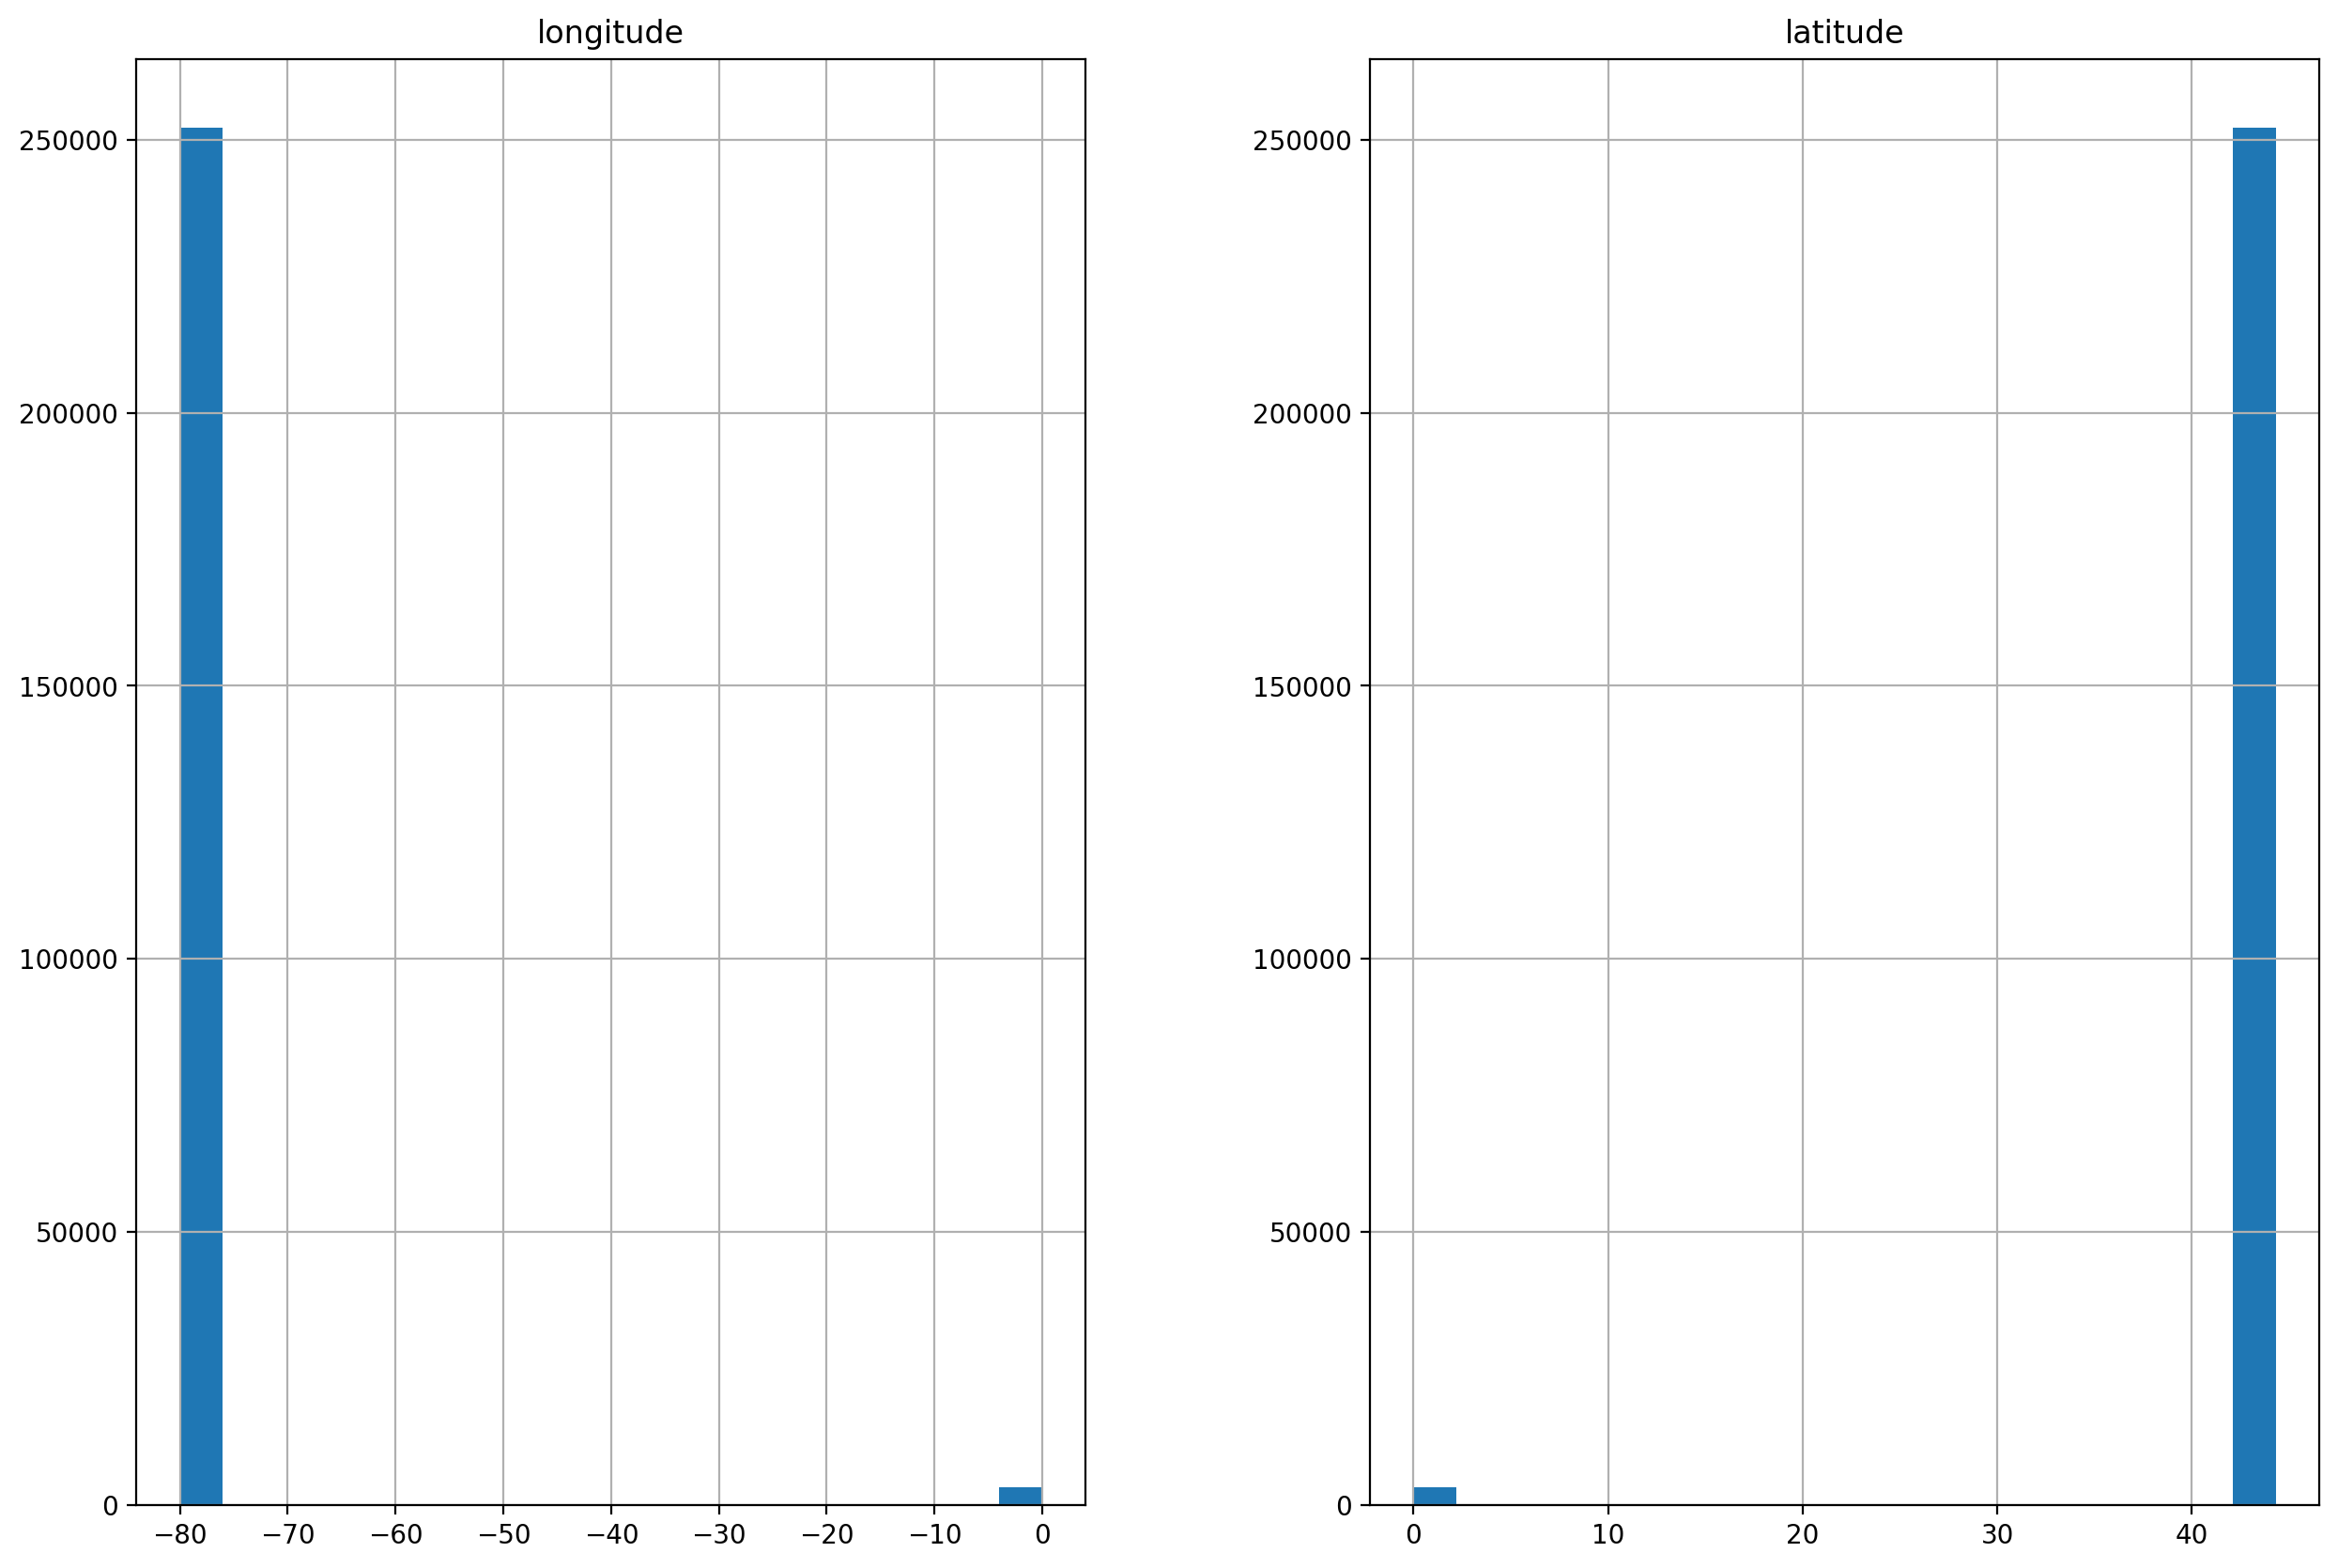

In [73]:
# missing longitude and latitude values are stored as 0
mci_df[['longitude','latitude']].hist(bins=20)

In [74]:
mci_df.loc[(mci_df['longitude'] == 0) & (mci_df['latitude'] == 0), ["neighbourhood", "hood_id"]].value_counts()

neighbourhood                      hood_id
NSA                                NSA        3027
Wexford/Maryvale                   119          50
Yorkdale-Glen Park                 31           38
West Hill                          136          14
Bay Street Corridor                76           13
York University Heights            27           11
Bendale                            127          11
Glenfield-Jane Heights             25           10
Kennedy Park                       124           7
Mimico                             17            5
Tam O'Shanter-Sullivan             118           5
Pelmo Park-Humberlea               23            4
Downsview-Roding-CFB               26            4
Highland Creek                     134           4
Victoria Village                   43            4
Newtonbrook East                   50            4
Clairlea-Birchmount                120           4
Bathurst Manor                     34            4
Black Creek                        24  

### Estimate with given neighbourhood

In [75]:
# We can only estimate the location for those crimes with a neighbourhood associated to them 
# Drow rows without information about location and associated neighbourhood
mci_df = mci_df[~((mci_df['longitude'] == 0) & (mci_df['latitude'] == 0) & (mci_df['neighbourhood'] == "NSA"))].reset_index(drop=True)

In [76]:
missing_location = mci_df.loc[(mci_df['longitude'] == 0) & (mci_df['latitude'] == 0)].index
mci_df.loc[missing_location]

occurrence_unique_id occurrence_date  occurrence_year occurrence_month  \
1372         GO-20181222720      2018-07-05             2018             July   
3807         GO-20212303850      2021-04-25             2021            April   
6690         GO-20171616525      2017-09-06             2017        September   
7726         GO-20192152732      2019-11-07             2019         November   
9329         GO-20141665589      2014-03-08             2014            March   
...                     ...             ...              ...              ...   
235272       GO-20181939820      2018-10-20             2018          October   
236426       GO-20201116842      2020-06-17             2020             June   
239428       GO-20191794829      2019-09-18             2019        September   
241392       GO-20181409483      2018-07-31             2018             July   
242303       GO-20191808146      2019-09-20             2019        September   

        occurrence_day  occurrence_dayofyear occurrence_dayofweek      MCI  \
1372                 5                   186             Thursday  Assault   
3807                25                   115               Sunday  Assault   
6690                 6                   249            Wednesday  Assault   
7726                 7                   311             Thursday  Assault   
9329                 8                    67             Saturday  Assault   
...                ...                   ...                  ...      ...   
235272              20                   293             Saturday  Robbery   
236426              17                   169            Wednesday  Assault   
239428              18                   261            Wednesday  Assault   
241392              31                   212              Tuesday  Assault   
242303              20                   263               Friday  Robbery   

       hood_id                      neighbourhood  longitude  latitude  \
1372         1             West Humber-Clairville        0.0       0.0   
3807         1             West Humber-Clairville        0.0       0.0   
6690         2  Mount Olive-Silverstone-Jamestown        0.0       0.0   
7726         2  Mount Olive-Silverstone-Jamestown        0.0       0.0   
9329         3       Thistletown-Beaumond Heights        0.0       0.0   
...        ...                                ...        ...       ...   
235272     136                          West Hill        0.0       0.0   
236426     136                          West Hill        0.0       0.0   
239428     137                             Woburn        0.0       0.0   
241392     138                      Eglinton East        0.0       0.0   
242303     138                      Eglinton East        0.0       0.0   

        occurrence_quarter  
1372                     3  
3807                     2  
6690                     3  
7726                     4  
9329                     1  
...                    ...  
235272                   4  
236426                   2  
239428                   3  
241392                   3  
242303                   3  

[237 rows x 13 columns]

In [77]:
missing_count = mci_df.loc[missing_location]['hood_id'].value_counts()
missing_count = missing_count.reset_index(drop=False).rename(columns={'index':'hood_id', 'hood_id':'count'})
missing_count

hood_id  count
0      119     50
1       31     38
2      136     14
3       76     13
4      127     11
5       27     11
6       25     10
7      124      7
8       17      5
9      118      5
10      26      4
11      43      4
12      34      4
13      50      4
14      23      4
15     120      4
16     134      4
17      24      3
18      21      3
19      51      2
20     117      2
21     121      2
22      95      2
23      70      2
24       1      2
25       2      2
26      48      2
27     138      2
28      73      1
29      19      1
30     137      1
31       3      1
32       5      1
33     128      1
34       7      1
35     123      1
36       8      1
37      14      1
38      32      1
39      49      1
40      55      1
41      41      1
42     102      1
43      98      1
44      97      1
45      46      1
46      82      1
47      77      1
48      36      1

### Generate random locations given a neighbourhood

In [78]:
# randomly generate points within a defined neighbourhood
# https://gis.stackexchange.com/questions/207731/generating-random-coordinates-in-multipolygon-in-python
def generate_random(number, hood_id):
    selected_neighbourhood = neighbourhoods.loc[neighbourhoods['hood_id'] == str(hood_id)]
    polygon = selected_neighbourhood['geometry']
    points_x = []
    points_y = []
    count = 0
    try: 
        minx, miny, maxx, maxy = polygon.unique().bounds.flatten().tolist()
    except ValueError:
        print(selected_neighbourhood)
        print(f"No geometry for {hood_id}")
    while len(points_x) < number:
        pnt = shapely.geometry.Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
        if polygon.contains(pnt).values[0]:
            points_x.append(pnt.x)
            points_y.append(pnt.y)
        count += 1
    print(f"{count} points generated but only include the {len(points_x)} points within the neighbourhood")
    return pd.Series([points_x, points_y])

12 points generated but only include the 10 points within the neighbourhood


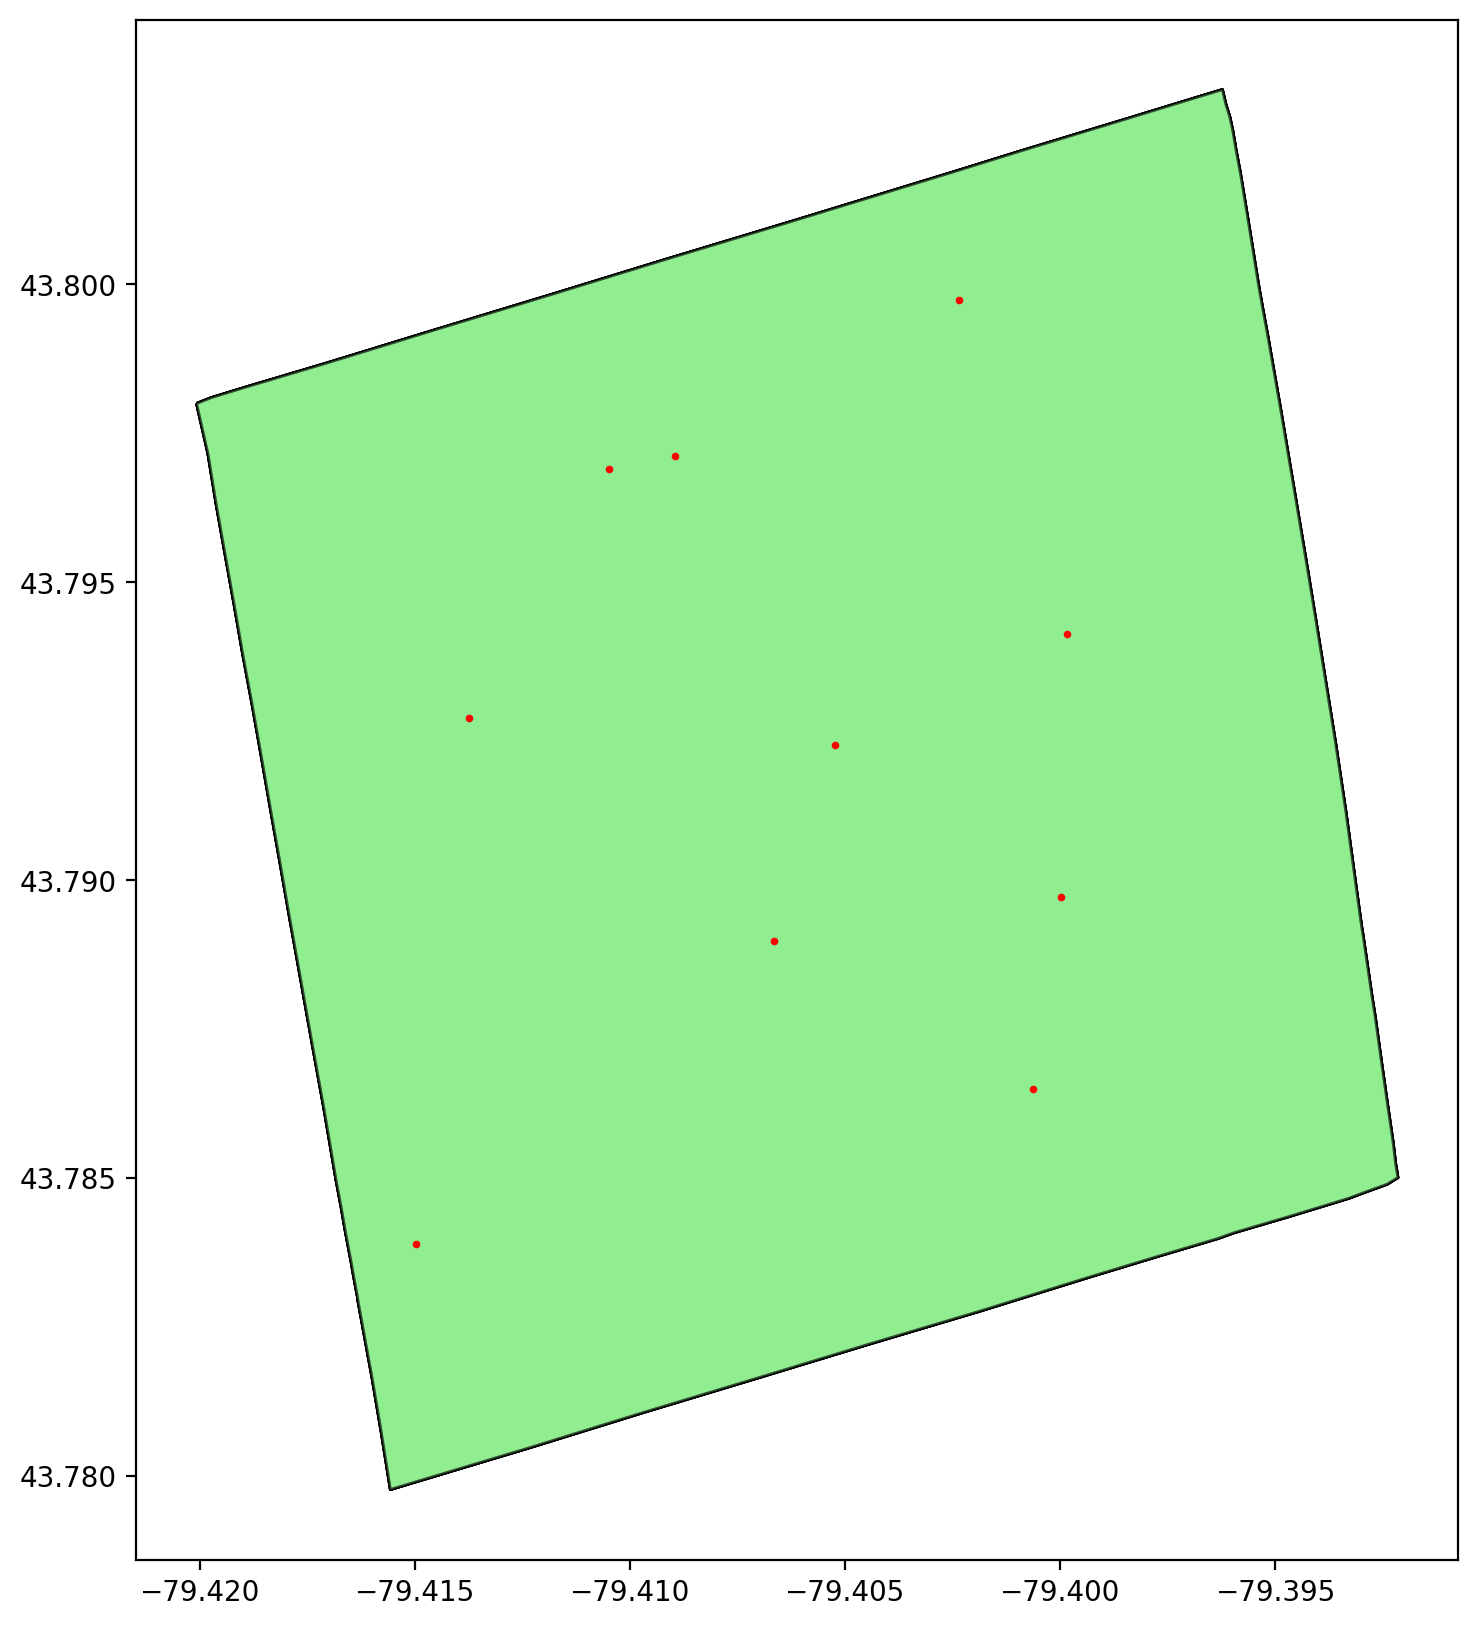

In [79]:
# select one hood_id to test
hood = 50
np.random.seed(123)
random_x, random_y = generate_random(10, hood)

# random points should lie within the neighbourhood
# no red dots should be outside the neighbourhood
ax = neighbourhoods.loc[neighbourhoods['hood_id'] == str(hood)].plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
plt.scatter(random_x, random_y, 
            color = 'red', s = 3)

In [80]:
np.random.seed(123)
missing_count[['longitude', 'latitude']] = missing_count.apply(lambda x: generate_random(x['count'],x['hood_id']), axis=1)

66 points generated but only include the 50 points within the neighbourhood
69 points generated but only include the 38 points within the neighbourhood
25 points generated but only include the 14 points within the neighbourhood
28 points generated but only include the 13 points within the neighbourhood
17 points generated but only include the 11 points within the neighbourhood
22 points generated but only include the 11 points within the neighbourhood
14 points generated but only include the 10 points within the neighbourhood
13 points generated but only include the 7 points within the neighbourhood
10 points generated but only include the 5 points within the neighbourhood
8 points generated but only include the 5 points within the neighbourhood
10 points generated but only include the 4 points within the neighbourhood
7 points generated but only include the 4 points within the neighbourhood
9 points generated but only include the 4 points within the neighbourhood
6 points generated bu

In [81]:
# random locations generated for each neighbourhood with missing long and lat values
missing_count['len'] = missing_count['longitude'].apply(lambda x: len(x))
missing_count

hood_id  count                                          longitude  \
0      119     50  [-79.29057129960066, -79.31026462964951, -79.2...   
1       31     38  [-79.45211389854785, -79.45797803654146, -79.4...   
2      136     14  [-79.18738817349912, -79.17250043362482, -79.1...   
3       76     13  [-79.37820160936677, -79.38773131195, -79.3936...   
4      127     11  [-79.24575754019779, -79.26238962382116, -79.2...   
5       27     11  [-79.49997143196524, -79.49168495988148, -79.4...   
6       25     10  [-79.4962804556188, -79.51357074419671, -79.51...   
7      124      7  [-79.25332406103357, -79.27330484430671, -79.2...   
8       17      5  [-79.50946059598944, -79.50593095054452, -79.4...   
9      118      5  [-79.29307510478209, -79.29760960208071, -79.2...   
10      26      4  [-79.48710228759032, -79.51891905736781, -79.5...   
11      43      4  [-79.30576574606856, -79.31722542009688, -79.3...   
12      34      4  [-79.43833667715624, -79.45148968542752, -79.4...   
13      50      4  [-79.40153651430937, -79.40047577812486, -79.4...   
14      23      4  [-79.53012641855607, -79.51880265473521, -79.5...   
15     120      4  [-79.28681297517284, -79.28032329917161, -79.2...   
16     134      4  [-79.16048894917527, -79.17631020525452, -79.1...   
17      24      3  [-79.52803489265655, -79.51513875329157, -79.5...   
18      21      3  [-79.53314718489366, -79.56725667218358, -79.5...   
19      51      2           [-79.39362803241268, -79.40186015241665]   
20     117      2           [-79.32276836299228, -79.31962724130351]   
21     121      2             [-79.2797962066855, -79.2792070727044]   
22      95      2           [-79.40098531499923, -79.39032264881227]   
23      70      2           [-79.32279553423153, -79.33082654047394]   
24       1      2           [-79.57430494429225, -79.61737240007653]   
25       2      2           [-79.57663971323922, -79.58594297593453]   
26      48      2           [-79.34437629832857, -79.36288586356174]   
27     138      2            [-79.23810931527544, -79.2353835232249]   
28      73      1                               [-79.37007803068437]   
29      19      1                               [-79.52200250556047]   
30     137      1                               [-79.24645012336666]   
31       3      1                               [-79.55758124751159]   
32       5      1                               [-79.54887804549438]   
33     128      1                                 [-79.269625646537]   
34       7      1                               [-79.55784909583367]   
35     123      1                               [-79.23877122709457]   
36       8      1                               [-79.51442203932889]   
37      14      1                               [-79.55615817973327]   
38      32      1                               [-79.43080487660326]   
39      49      1                               [-79.37198377651953]   
40      55      1                               [-79.35681281473488]   
41      41      1                               [-79.40188315139446]   
42     102      1                               [-79.42822724342359]   
43      98      1                               [-79.37465111918915]   
44      97      1                               [-79.39482600210063]   
45      46      1                               [-79.33182088228381]   
46      82      1                               [-79.41630732027724]   
47      77      1                               [-79.37052697737472]   
48      36      1                               [-79.42646335532221]   

                                             latitude  len  
0   [43.738453134139256, 43.751184896547585, 43.74...   50  
1   [43.72600597006119, 43.705895166974635, 43.716...   38  
2   [43.763774779636535, 43.75829889101154, 43.761...   14  
3   [43.649825782282626, 43.66659265342764, 43.668...   13  
4   [43.75108405468279, 43.779392435678915, 43.749...   11  
5   [43.76991369028236, 43.755809629

In [83]:
# impute the missing long and lat values
for i in missing_count["hood_id"].unique():    
    index = (mci_df['hood_id'] == str(i)) & ((mci_df['longitude'] == 0) | (mci_df['latitude'] == 0))
    # mci_df.loc[index, ['longitude', 'latitude']] = 
    mci_df.loc[index, ['longitude', 'latitude']] = pd.DataFrame([np.where(mci_df.loc[index, 'longitude'] == 0, 
                                                                  missing_count[missing_count['hood_id'] == str(i)]['longitude'].values[0],
                                                                  mci_df.loc[index, 'longitude']),
                                                         np.where(mci_df.loc[index, 'latitude'] == 0, 
                                                                  missing_count[missing_count['hood_id'] == str(i)]['latitude'].values[0],
                                                                  mci_df.loc[index, 'latitude'])]).T.values

In [84]:
# check missing long and lat values are now imputed
mci_df.loc[missing_location]

occurrence_unique_id occurrence_date  occurrence_year occurrence_month  \
1372         GO-20181222720      2018-07-05             2018             July   
3807         GO-20212303850      2021-04-25             2021            April   
6690         GO-20171616525      2017-09-06             2017        September   
7726         GO-20192152732      2019-11-07             2019         November   
9329         GO-20141665589      2014-03-08             2014            March   
...                     ...             ...              ...              ...   
235272       GO-20181939820      2018-10-20             2018          October   
236426       GO-20201116842      2020-06-17             2020             June   
239428       GO-20191794829      2019-09-18             2019        September   
241392       GO-20181409483      2018-07-31             2018             July   
242303       GO-20191808146      2019-09-20             2019        September   

        occurrence_day  occurrence_dayofyear occurrence_dayofweek      MCI  \
1372                 5                   186             Thursday  Assault   
3807                25                   115               Sunday  Assault   
6690                 6                   249            Wednesday  Assault   
7726                 7                   311             Thursday  Assault   
9329                 8                    67             Saturday  Assault   
...                ...                   ...                  ...      ...   
235272              20                   293             Saturday  Robbery   
236426              17                   169            Wednesday  Assault   
239428              18                   261            Wednesday  Assault   
241392              31                   212              Tuesday  Assault   
242303              20                   263               Friday  Robbery   

       hood_id                      neighbourhood  longitude   latitude  \
1372         1             West Humber-Clairville -79.574305  43.687440   
3807         1             West Humber-Clairville -79.617372  43.715442   
6690         2  Mount Olive-Silverstone-Jamestown -79.576640  43.749697   
7726         2  Mount Olive-Silverstone-Jamestown -79.585943  43.748941   
9329         3       Thistletown-Beaumond Heights -79.557581  43.736732   
...        ...                                ...        ...        ...   
235272     136                          West Hill -79.177261  43.779363   
236426     136                          West Hill -79.171195  43.767556   
239428     137                             Woburn -79.246450  43.761537   
241392     138                      Eglinton East -79.238109  43.743020   
242303     138                      Eglinton East -79.235384  43.738620   

        occurrence_quarter  
1372                     3  
3807                     2  
6690                     3  
7726                     4  
9329                     1  
...                    ...  
235272                   4  
236426                   2  
239428                   3  
241392                   3  
242303                   3  

[237 rows x 13 columns]

### Add geometry for points

In [85]:
mci_df['geometry'] = mci_df.apply(lambda x: shapely.geometry.Point(x['longitude'], x['latitude']), axis=1)

c:\Users\willi\miniconda3\envs\police\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [86]:
# Documentation: The location of crime occurrences have been deliberately offset 
# to the nearest road intersection node 
# to protect the privacy of parties involved in the occurrence
mci_point = gpd.GeoDataFrame(mci_df, crs='epsg:' + str(epsg_3d), geometry='geometry')

<AxesSubplot:>

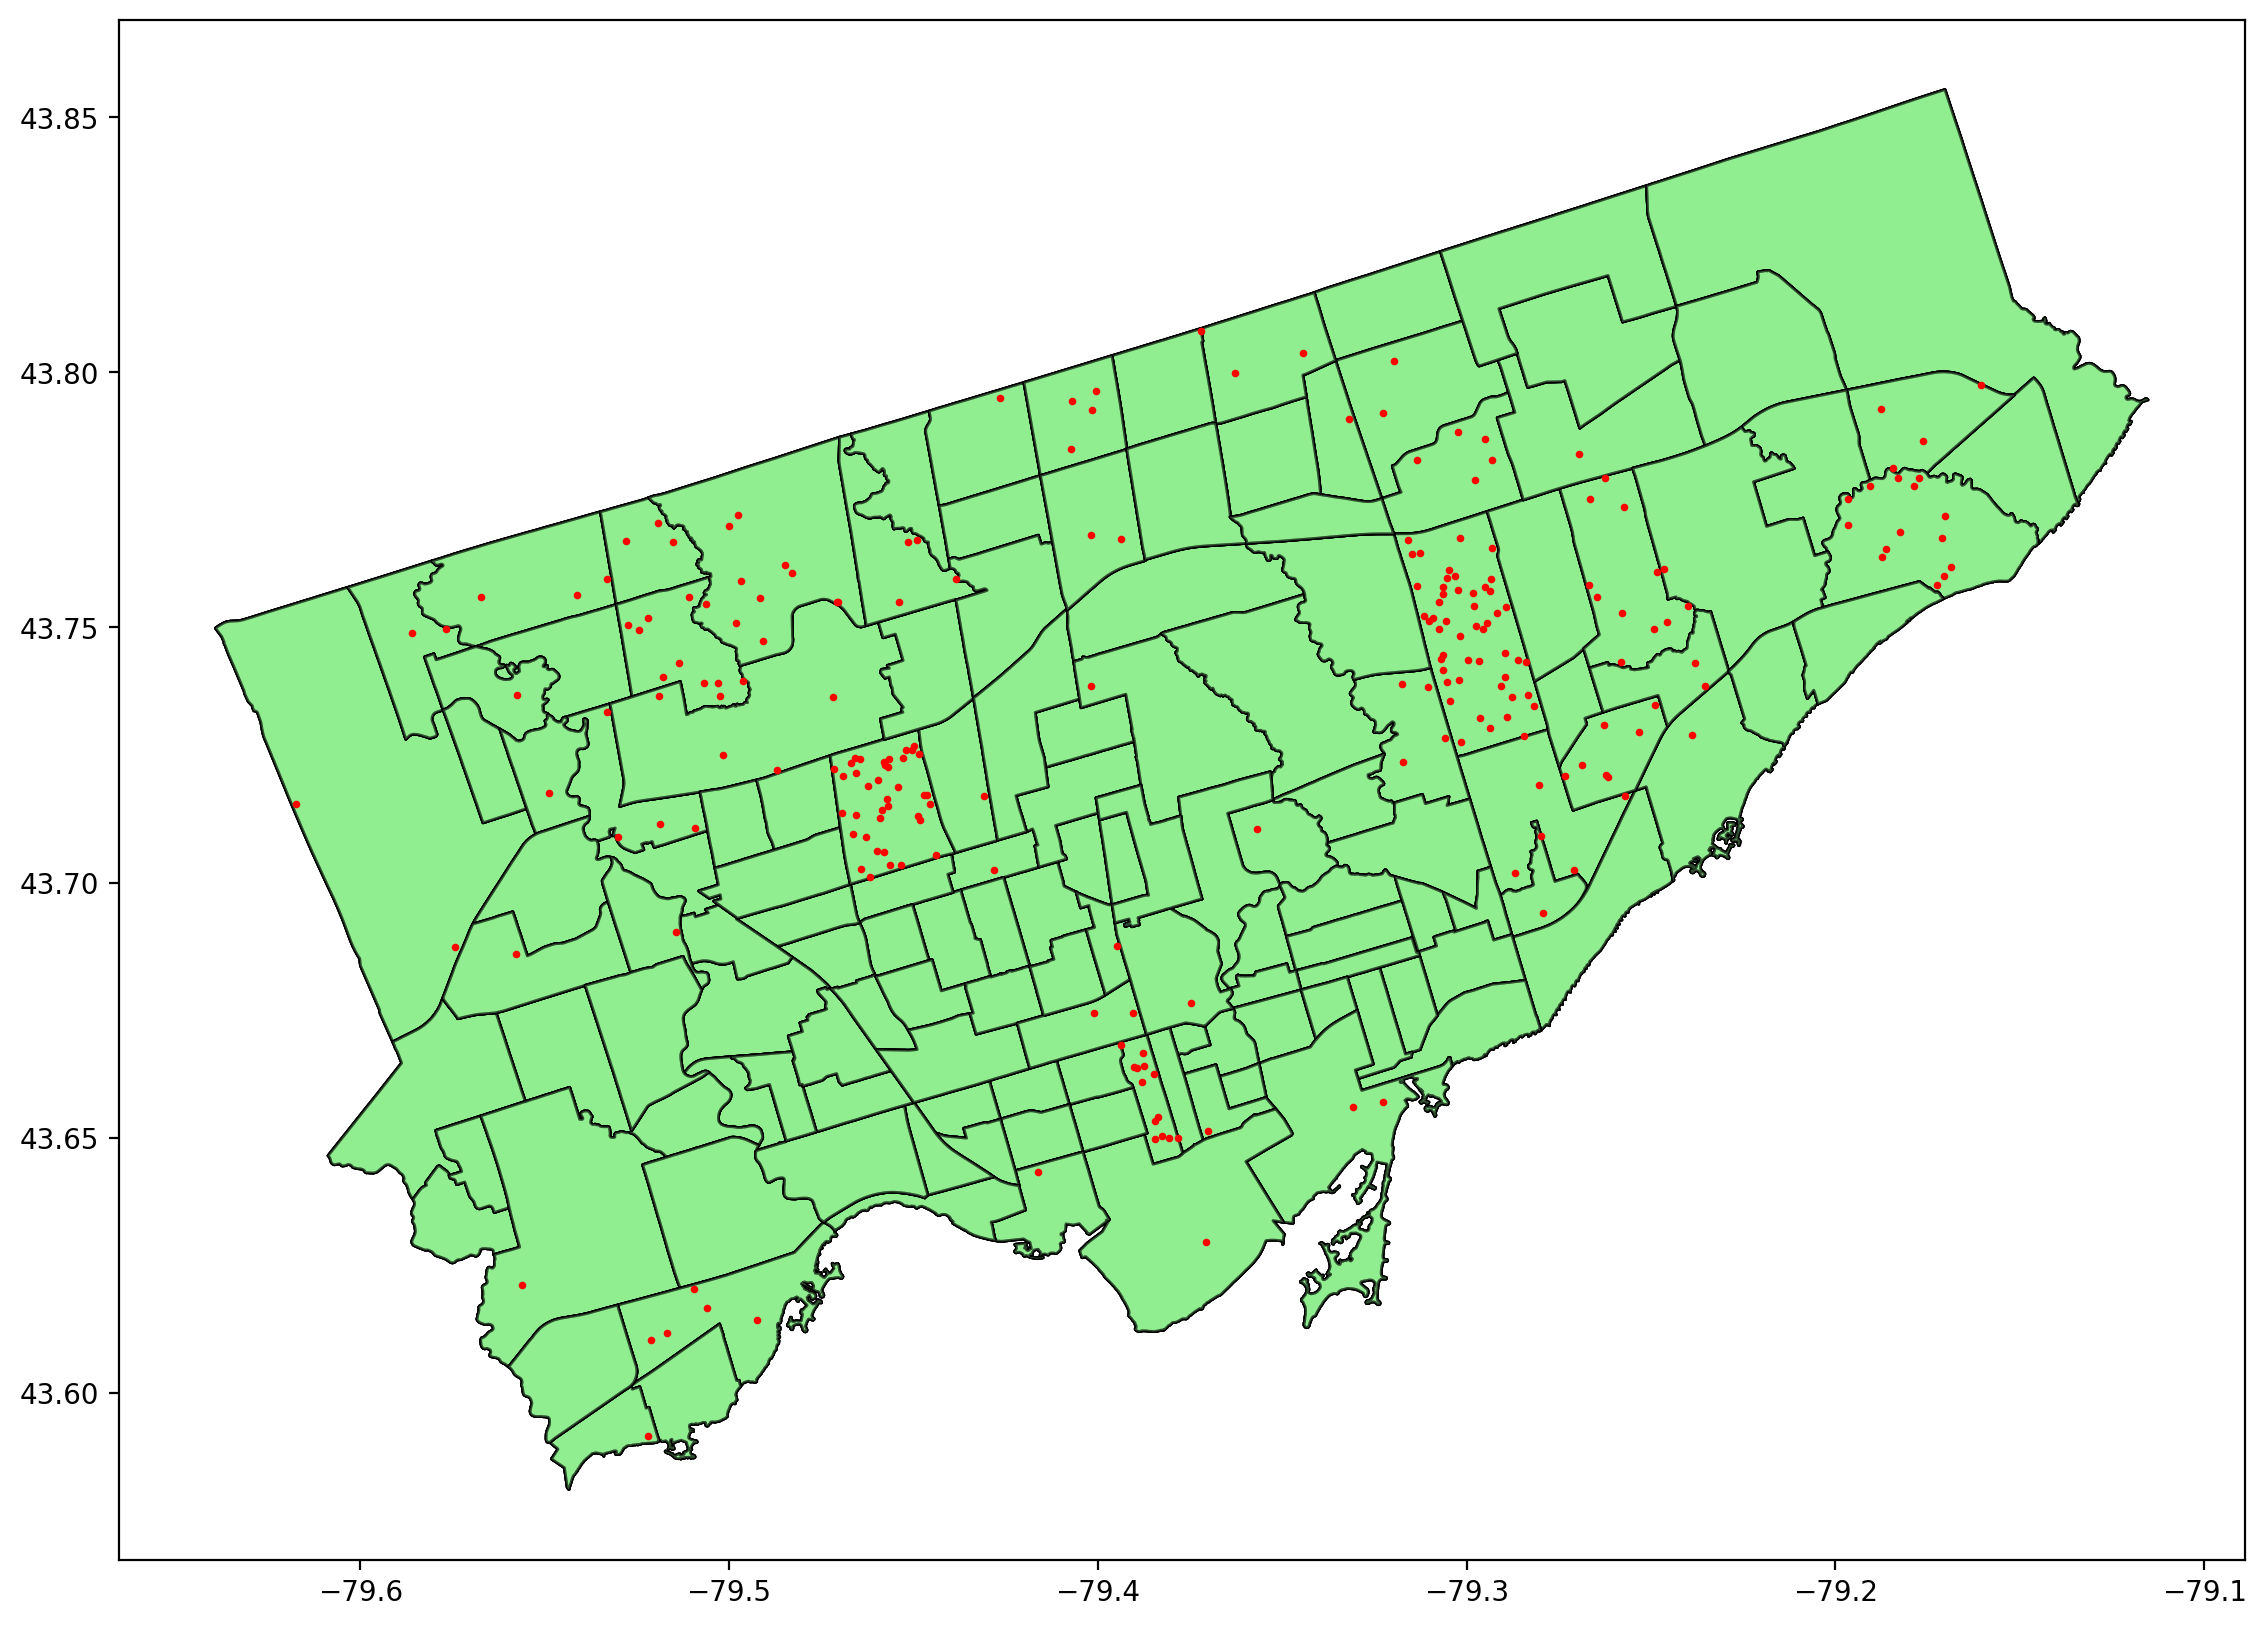

In [87]:
# show that random points generated to impute missing location are within the neighbourhoods
# no red dots should be outside the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
mci_point.loc[missing_location].plot(ax=ax, color = 'red', markersize = 3)

## NSA is not really 'Not Specified'

<AxesSubplot:>

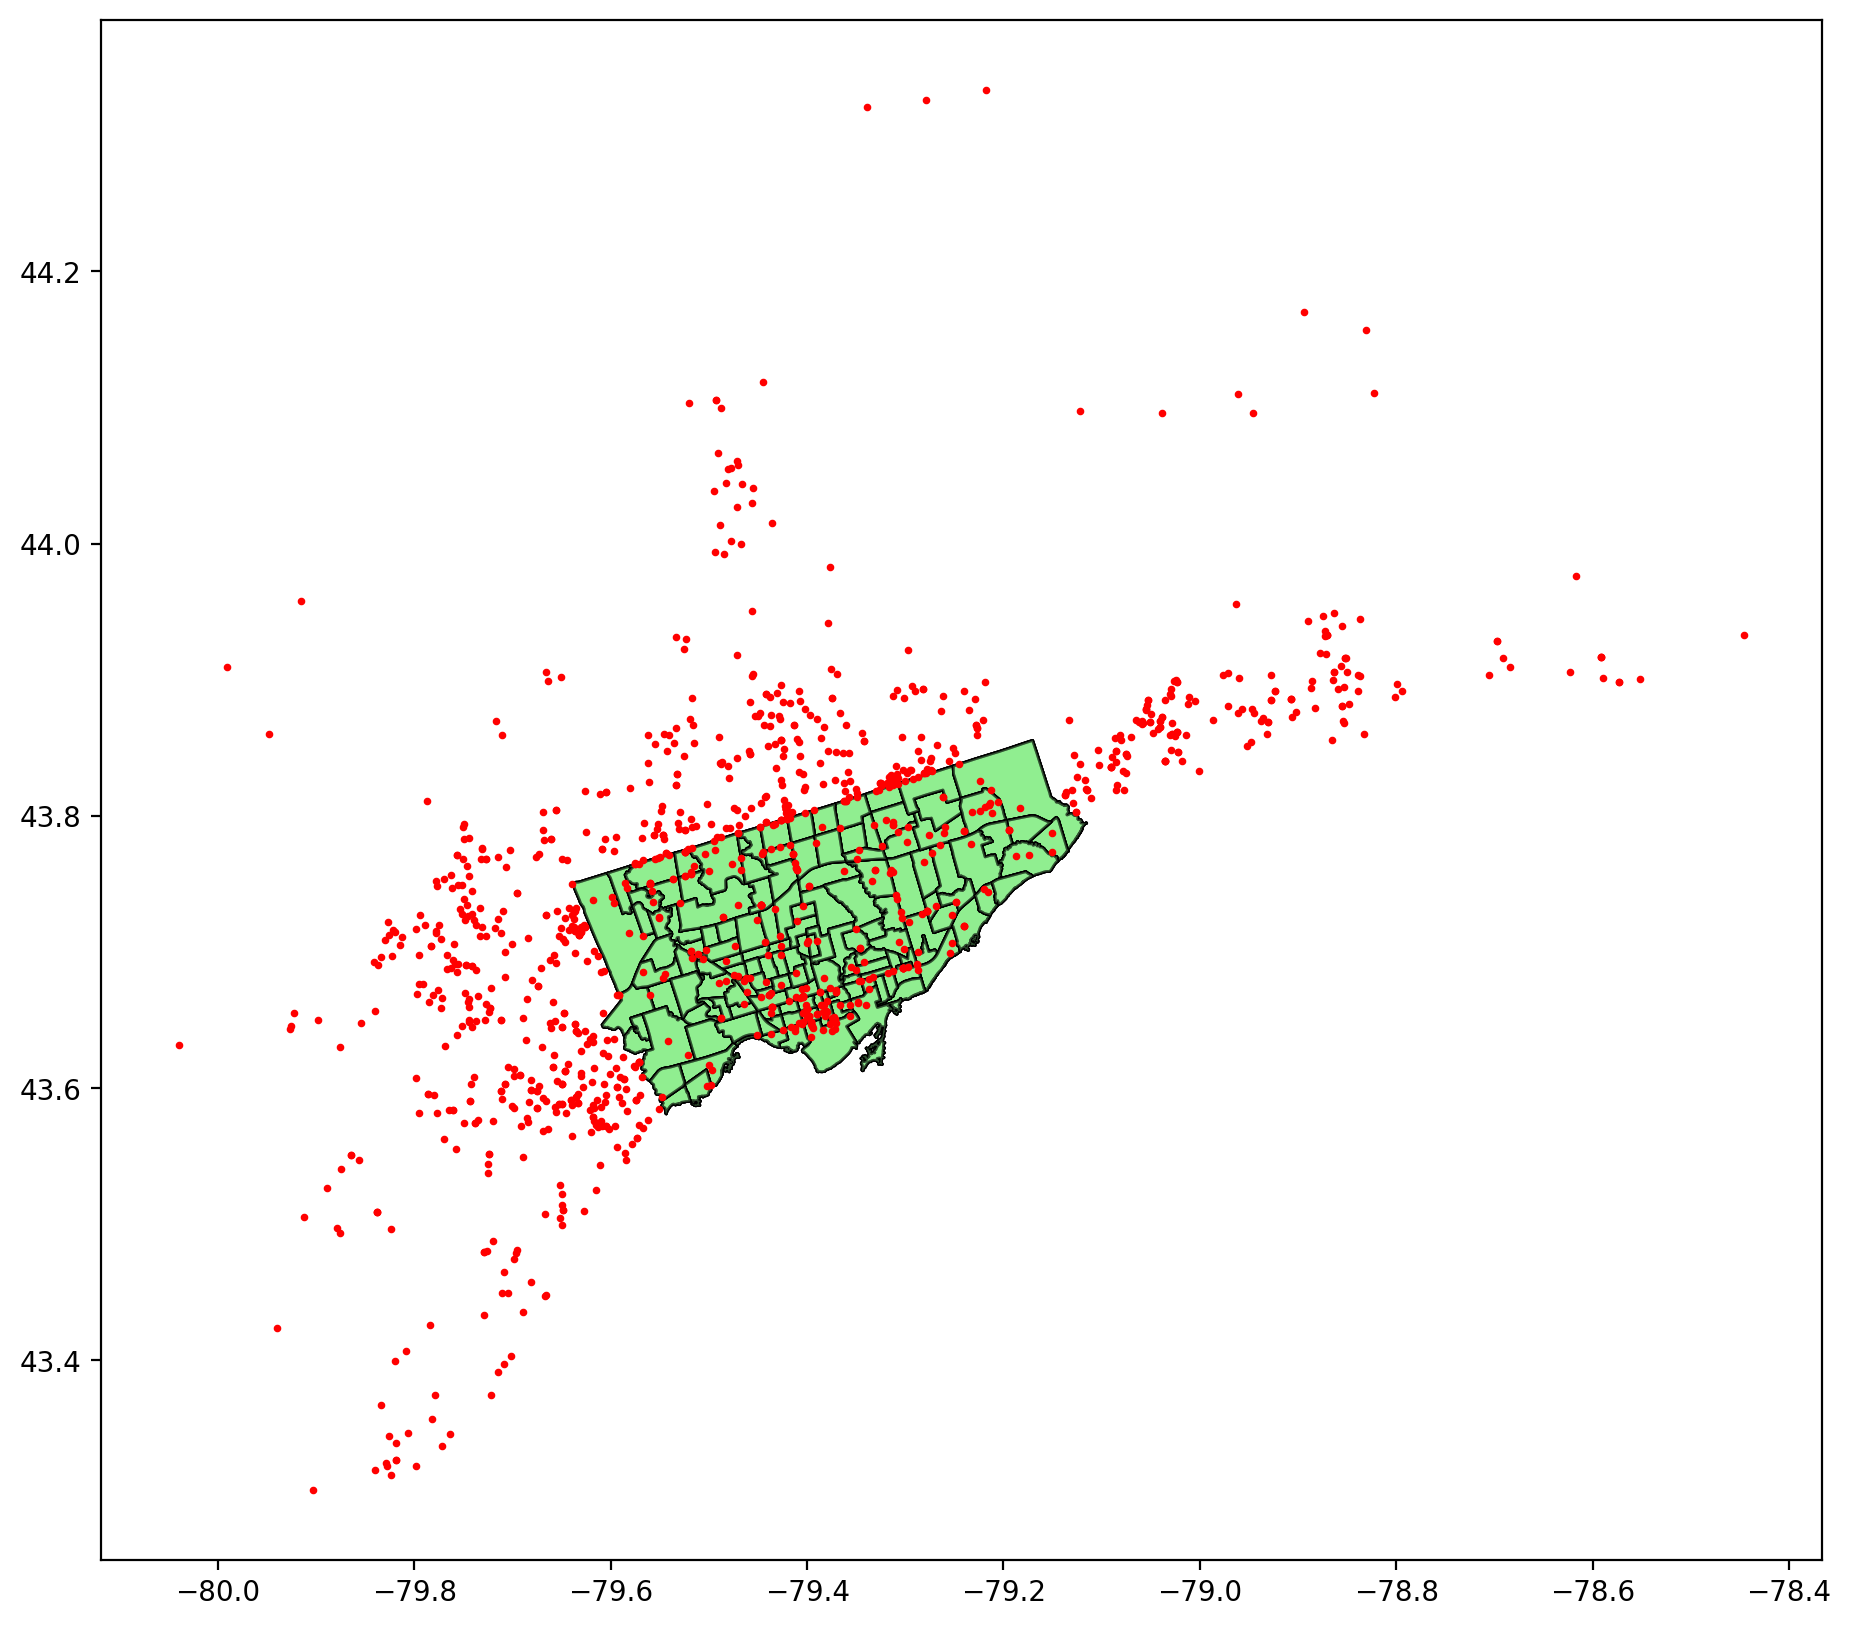

In [88]:
# some locations marked as NSA are actually within the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
mci_point[mci_point['neighbourhood'] == 'NSA'].plot(ax=ax, color = 'red', markersize = 3)

In [89]:
# get the points contained within the neighbourhoods
NSA_within_neighbourhood = gpd.sjoin(mci_point[mci_point['neighbourhood'] == 'NSA'], 
                                    neighbourhoods, 
                                    op='intersects')
mci_point.loc[NSA_within_neighbourhood.index, ['hood_id', 'neighbourhood']] = NSA_within_neighbourhood[['hood_id_right', 'neighbourhood_right']].values

c:\Users\willi\miniconda3\envs\police\lib\site-packages\IPython\core\interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


<AxesSubplot:>

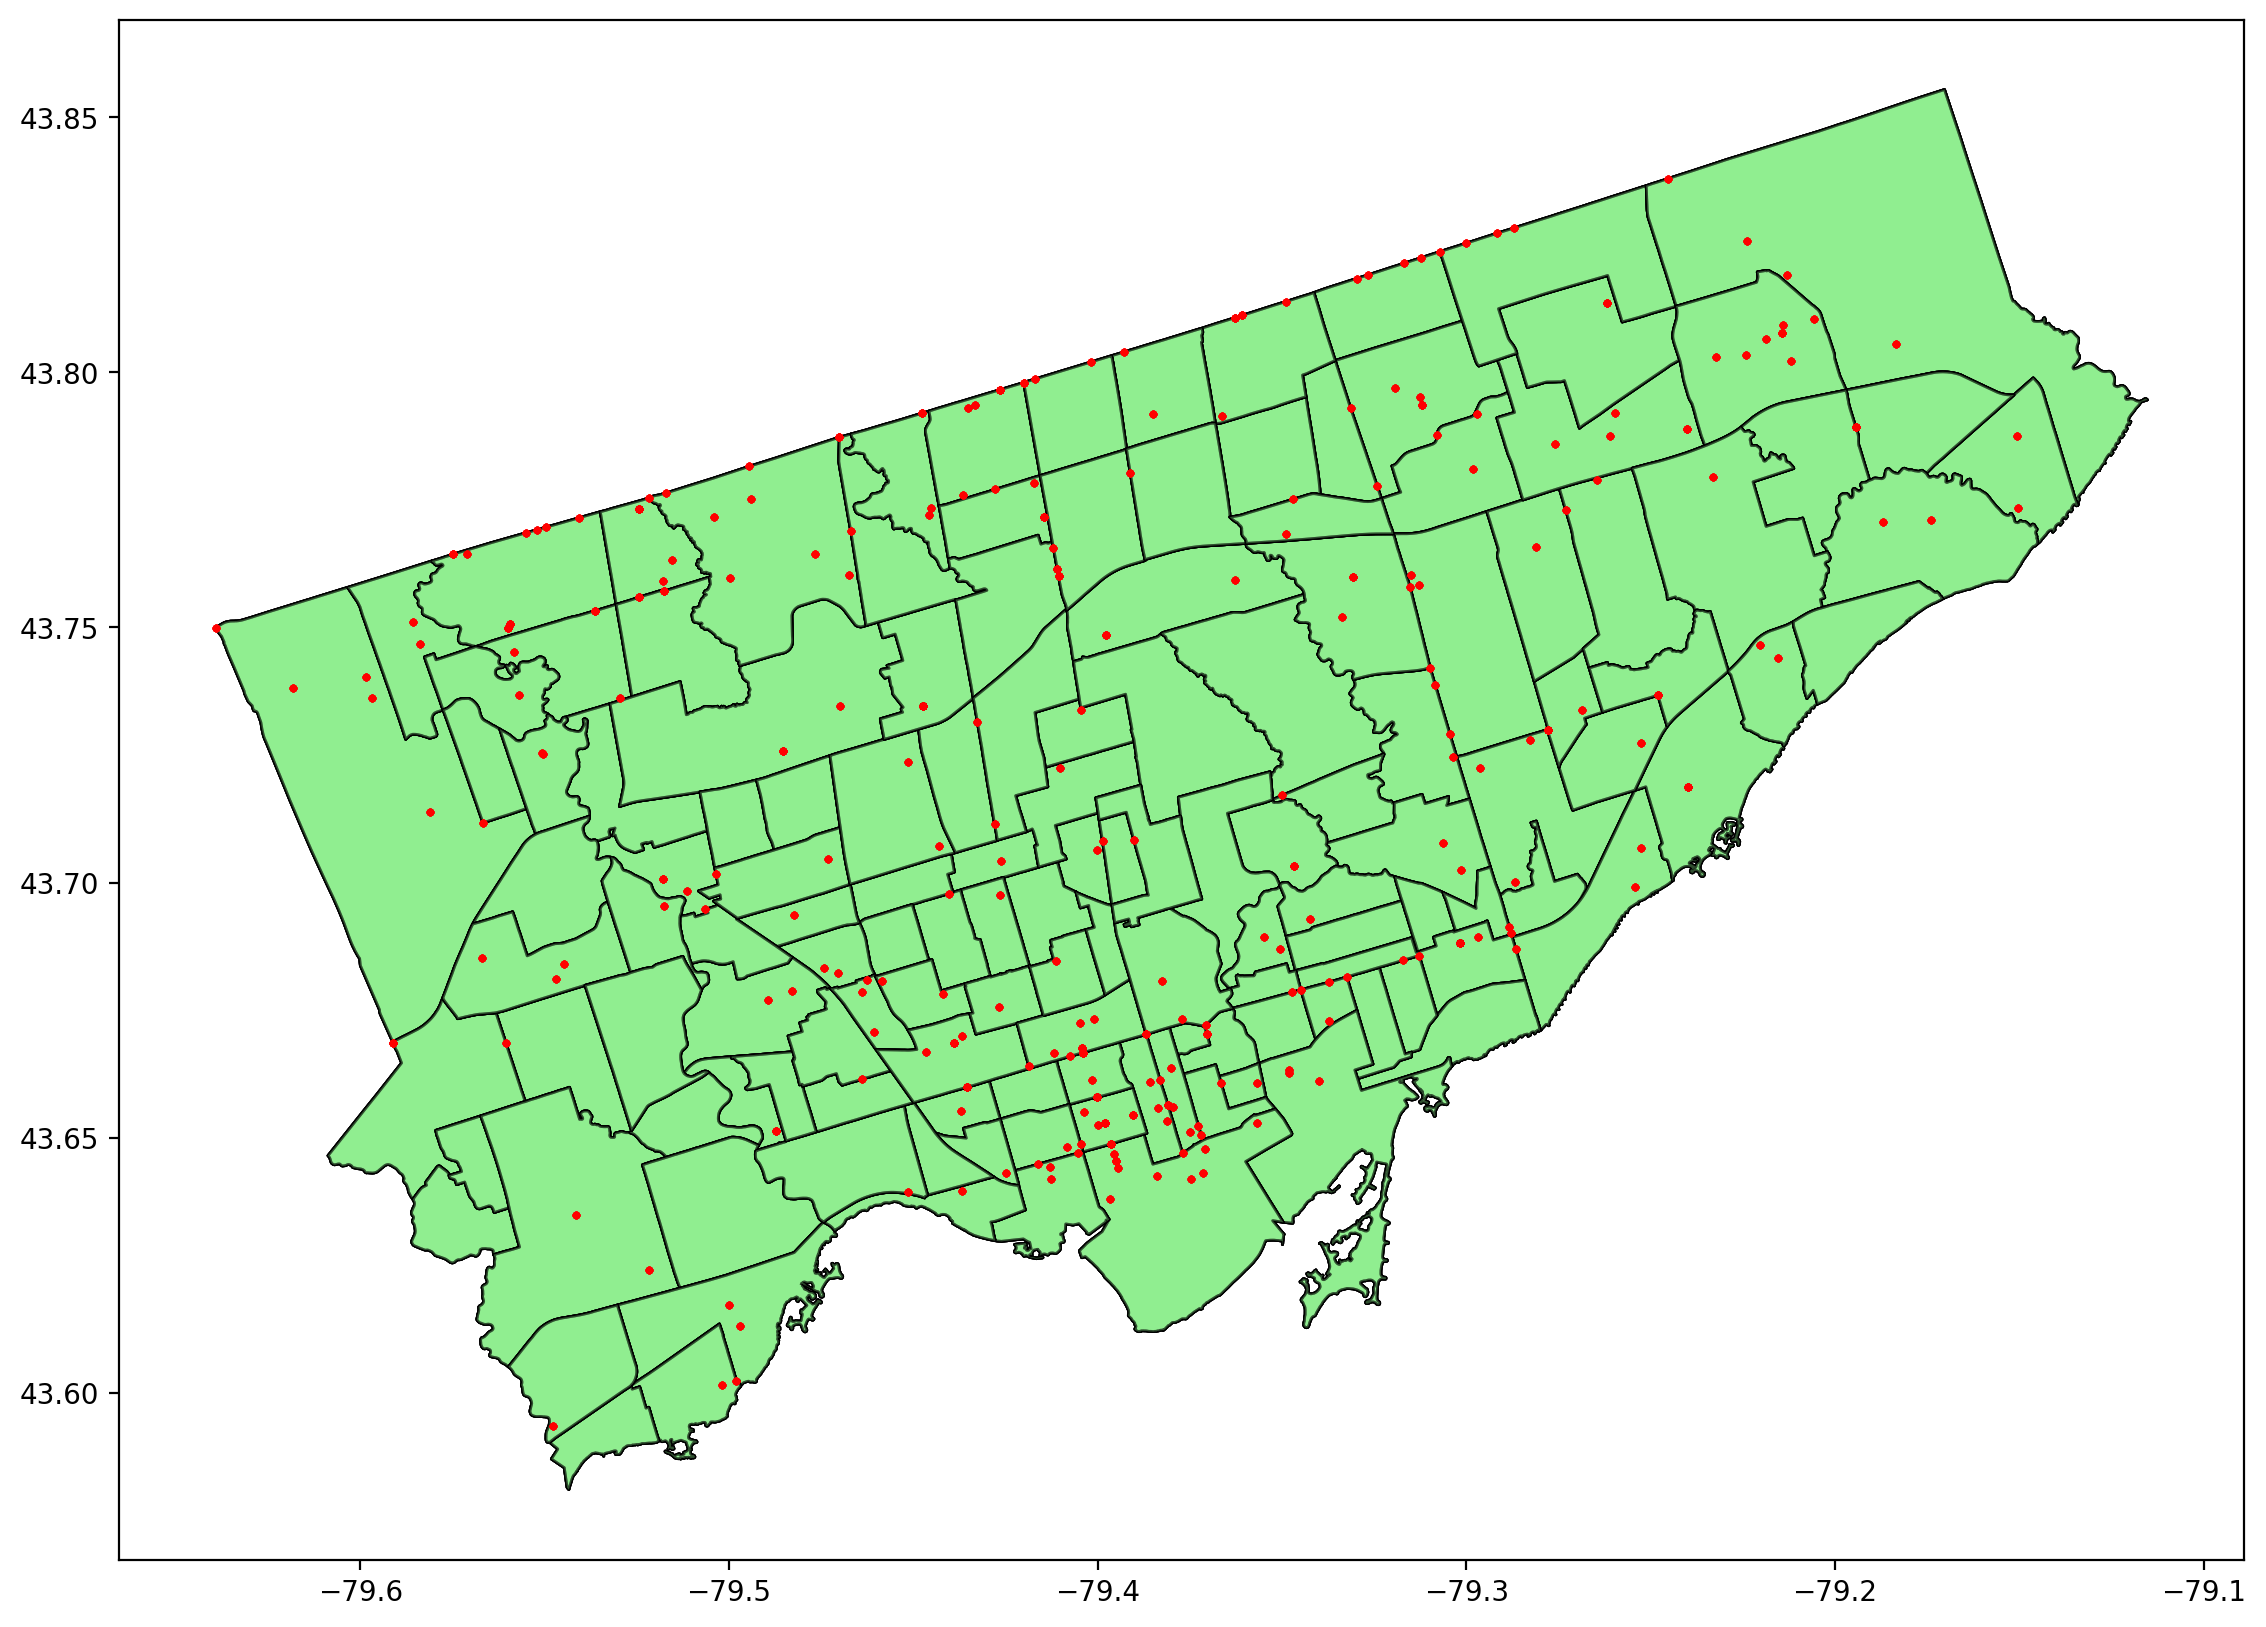

In [90]:
# check that we have correctly isolated only the locations within the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
mci_point.loc[NSA_within_neighbourhood.index].plot(ax=ax, color = 'red', markersize = 3)

<AxesSubplot:>

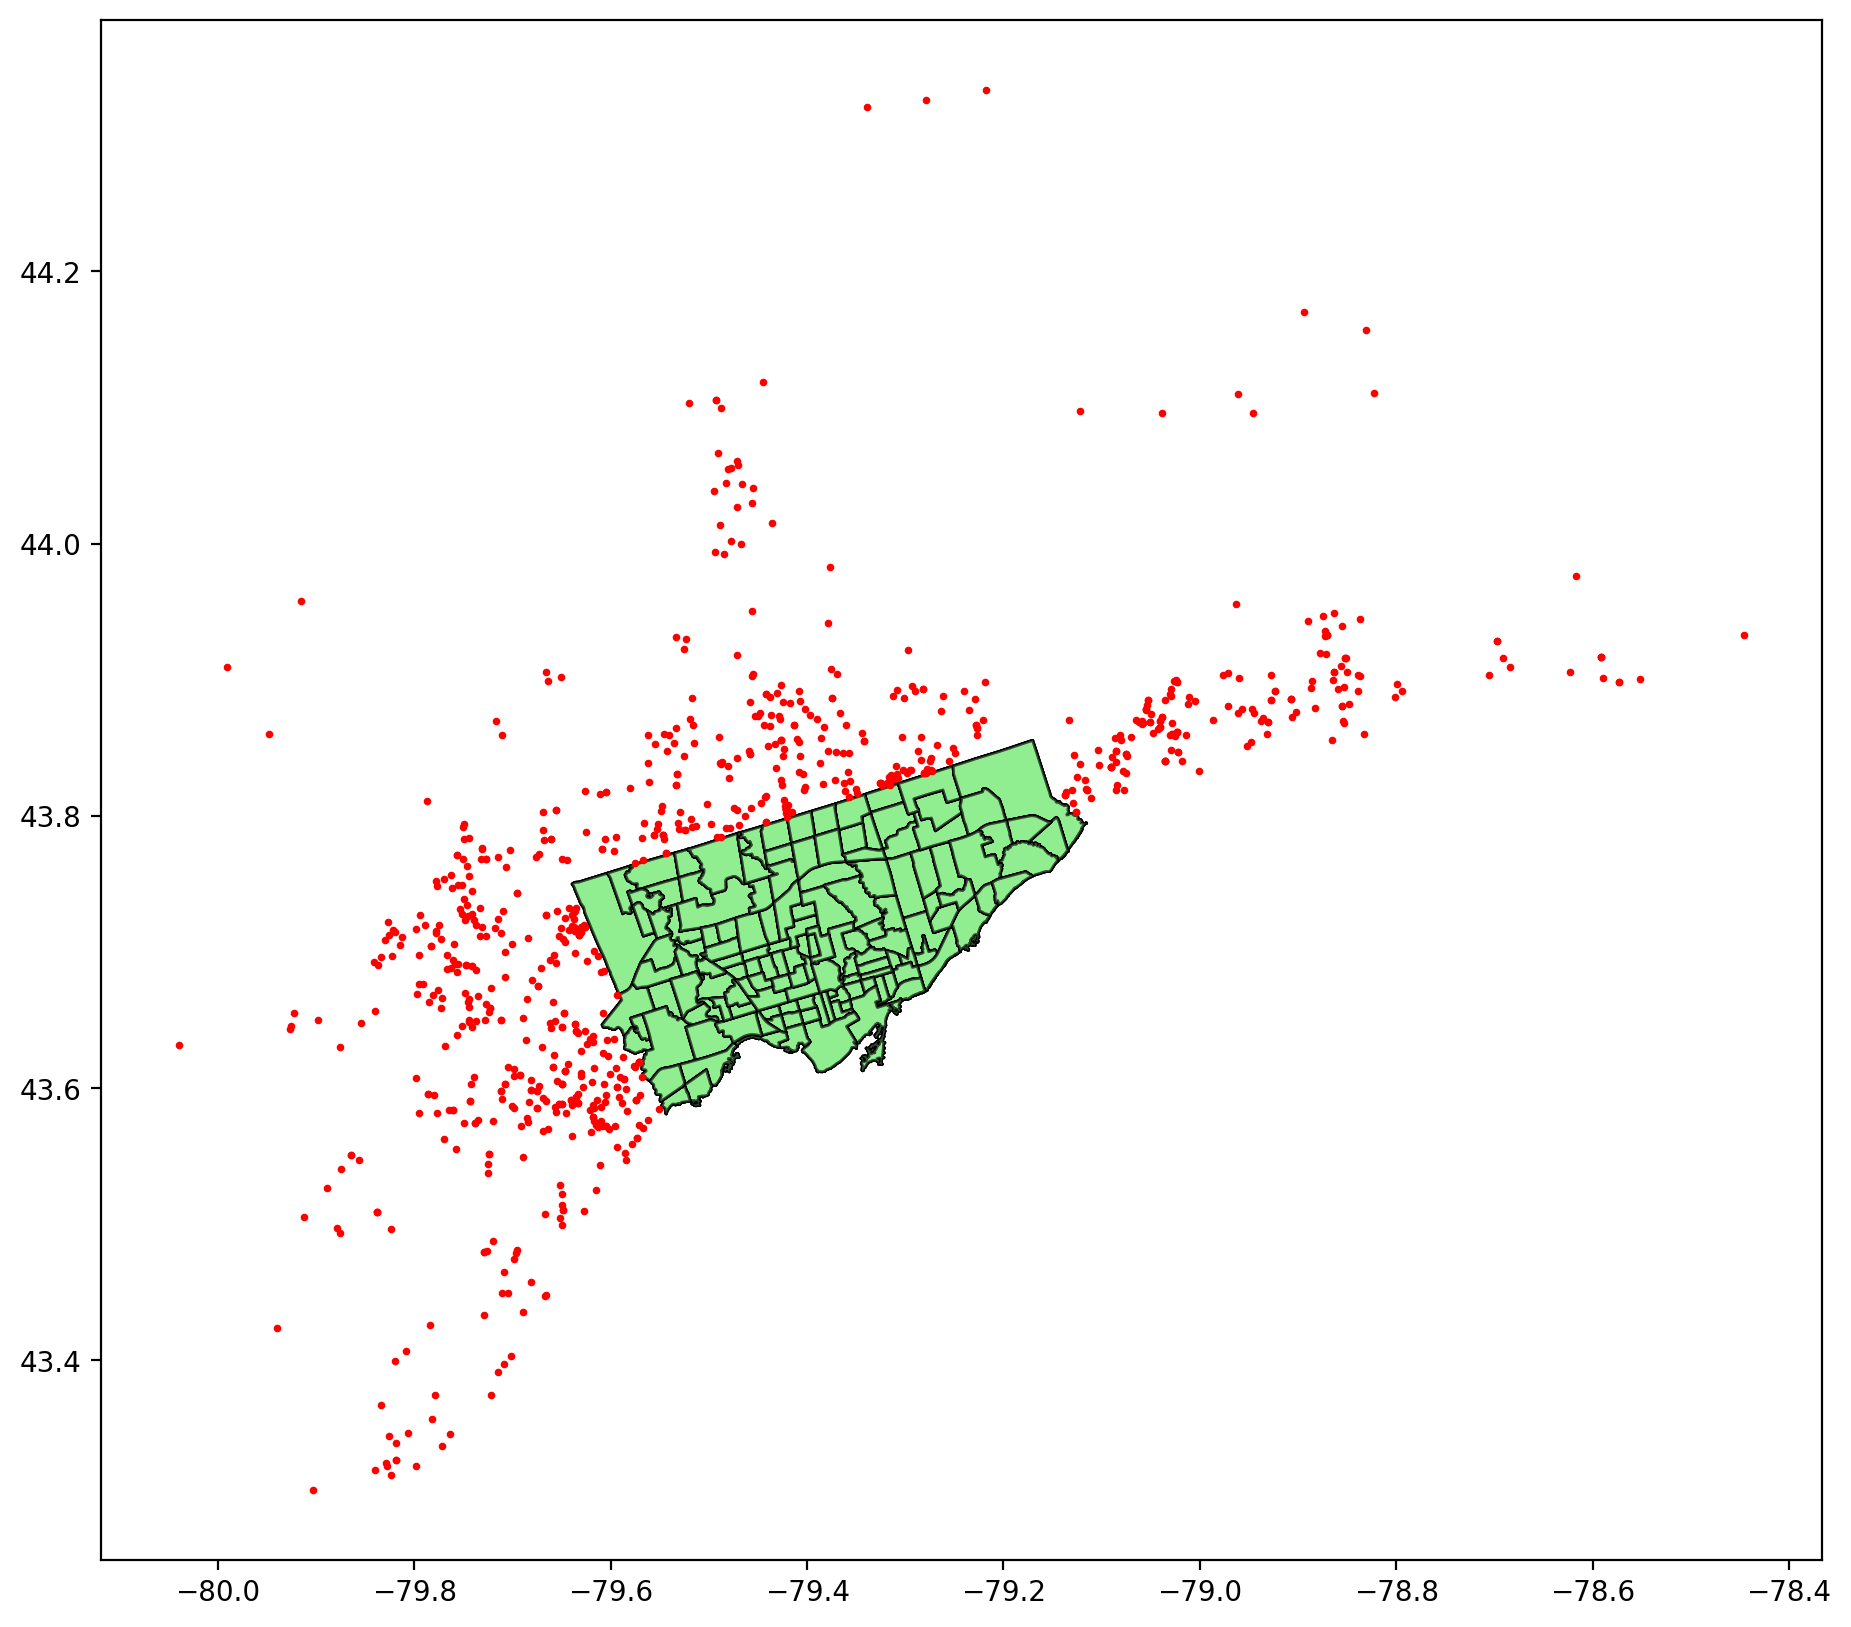

In [91]:
# check that now all the locations with neighbourhood as NSA are outside any out the neighbourhoods
# no red dots should be inside the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
mci_point[mci_point['neighbourhood'] == 'NSA'].plot(ax=ax, color = 'red', markersize = 3)

<AxesSubplot:>

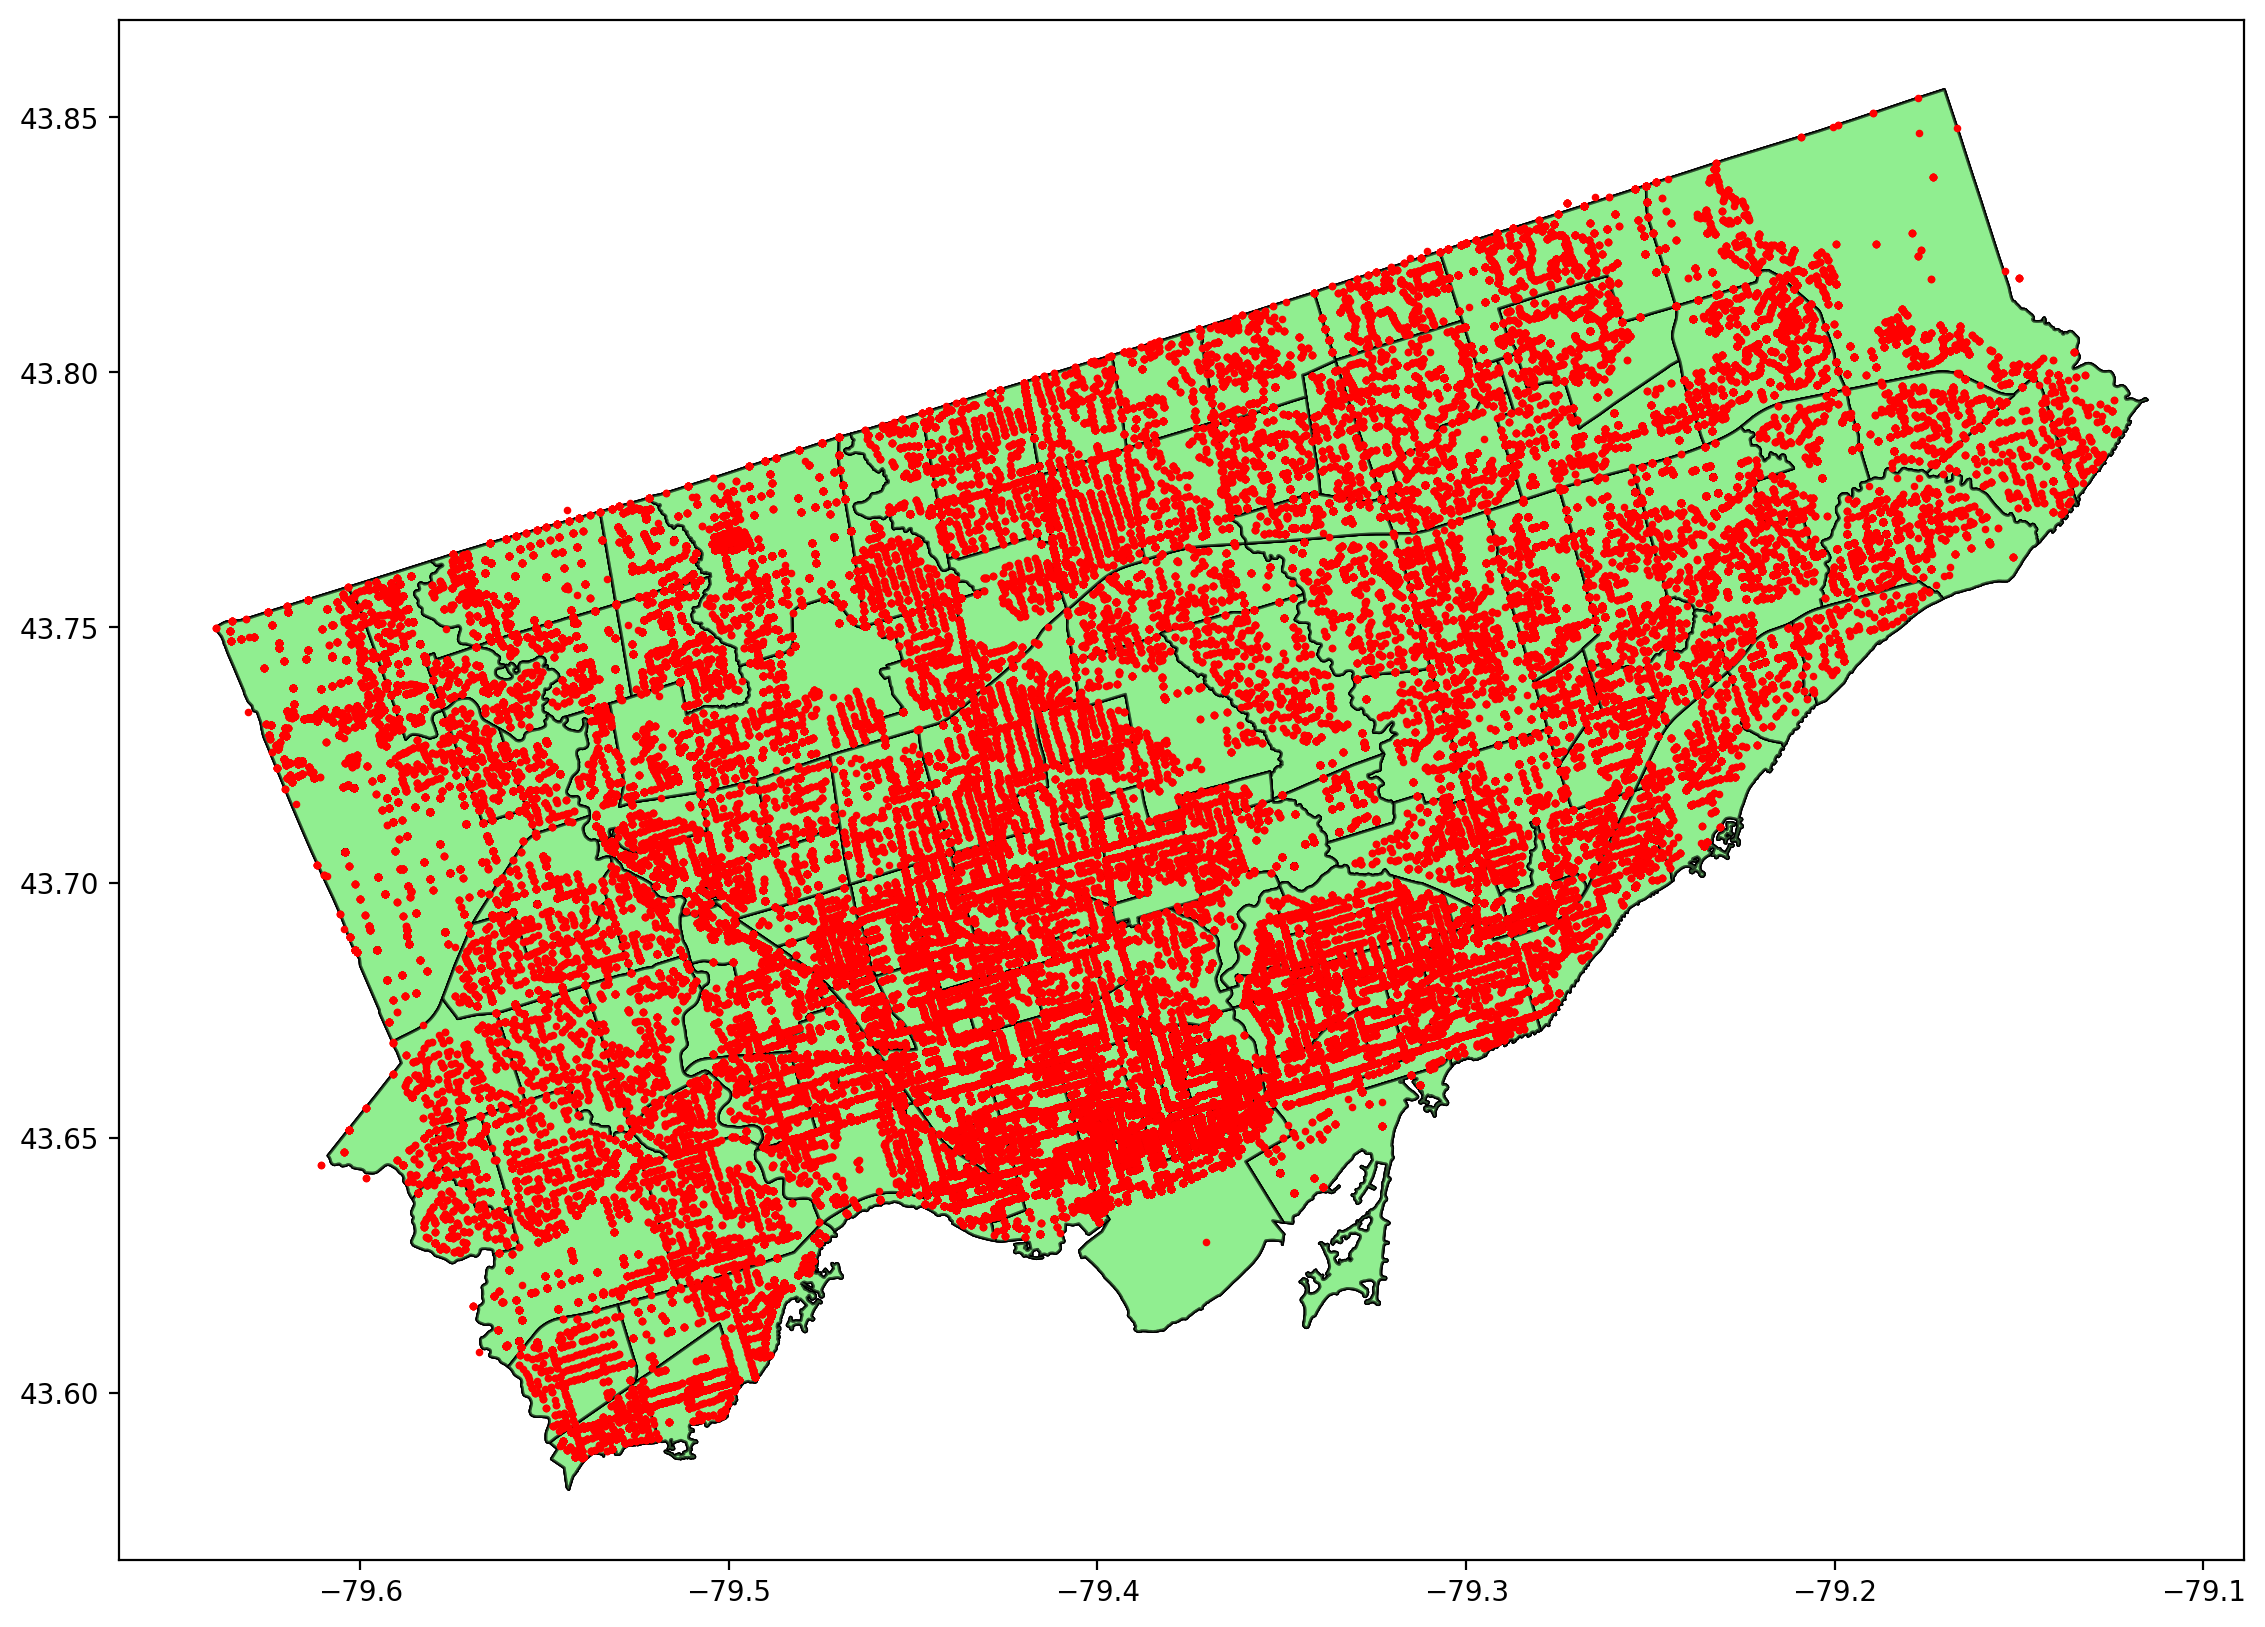

In [92]:
# now all the locations with neighbourhood not as NSA are inside the neighbourhoods
# no red dots should be outside the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
mci_point[mci_point['neighbourhood'] != 'NSA'].plot(ax=ax, color = 'red', markersize = 3)

# Output

In [93]:
mci_point

occurrence_unique_id occurrence_date  occurrence_year occurrence_month  \
0             GO-2015194909      2015-02-02             2015         February   
1             GO-2015216532      2015-02-03             2015         February   
2             GO-2015221290      2015-02-07             2015         February   
3             GO-2015227725      2015-02-08             2015         February   
4             GO-2015230168      2015-02-08             2015         February   
...                     ...             ...              ...              ...   
252499       GO-20191930830      2019-10-07             2019          October   
252500       GO-20191981086      2019-10-14             2019          October   
252501       GO-20192006688      2019-10-17             2019          October   
252502       GO-20192021028      2019-10-19             2019          October   
252503       GO-20192067798      2019-10-26             2019          October   

        occurrence_day  occurrence_dayofyear occurrence_dayofweek       MCI  \
0                    2                    33               Monday   Assault   
1                    3                    34              Tuesday   Assault   
2                    7                    38             Saturday   Assault   
3                    8                    39               Sunday   Assault   
4                    8                    39               Sunday   Assault   
...                ...                   ...                  ...       ...   
252499               7                   280               Monday  Homicide   
252500              14                   287               Monday  Homicide   
252501              17                   290             Thursday  Homicide   
252502              19                   292             Saturday  Homicide   
252503              26                   299             Saturday  Homicide   

       hood_id                      neighbourhood  longitude   latitude  \
0            1             West Humber-Clairville -79.606775  43.733147   
1            1             West Humber-Clairville -79.595459  43.737516   
2            1             West Humber-Clairville -79.622177  43.726176   
3            1             West Humber-Clairville -79.604057  43.731845   
4            1             West Humber-Clairville -79.575803  43.730521   
...        ...                                ...        ...        ...   
252499      60                   Woodbine-Lumsden -79.316228  43.698223   
252500       2  Mount Olive-Silverstone-Jamestown -79.587556  43.736889   
252501      48                  Hillcrest Village -79.358078  43.811142   
252502      87                  High Park-Swansea -79.471015  43.638261   
252503     104                Mount Pleasant West -79.390840  43.699494   

        occurrence_quarter                    geometry  
0                        1  POINT (-79.60678 43.73315)  
1                        1  POINT (-79.59546 43.73752)  
2                        1  POINT (-79.62218 43.72618)  
3                        1  POINT (-79.60406 43.73184)  
4                        1  POINT (-79.57580 43.73052)  
...                    ...                         ...  
252499                   4  POINT (-79.31623 43.69822)  
252500                   4  POINT (-79.58756 43.73689)  
252501                   4  POINT (-79.35808 43.81114)  
252502                   4  POINT (-79.47102 43.63826)  
252503                   4  POINT (-79.39084 43.69949)  

[252504 rows x 14 columns]

<AxesSubplot:xlabel='occurrence_year'>

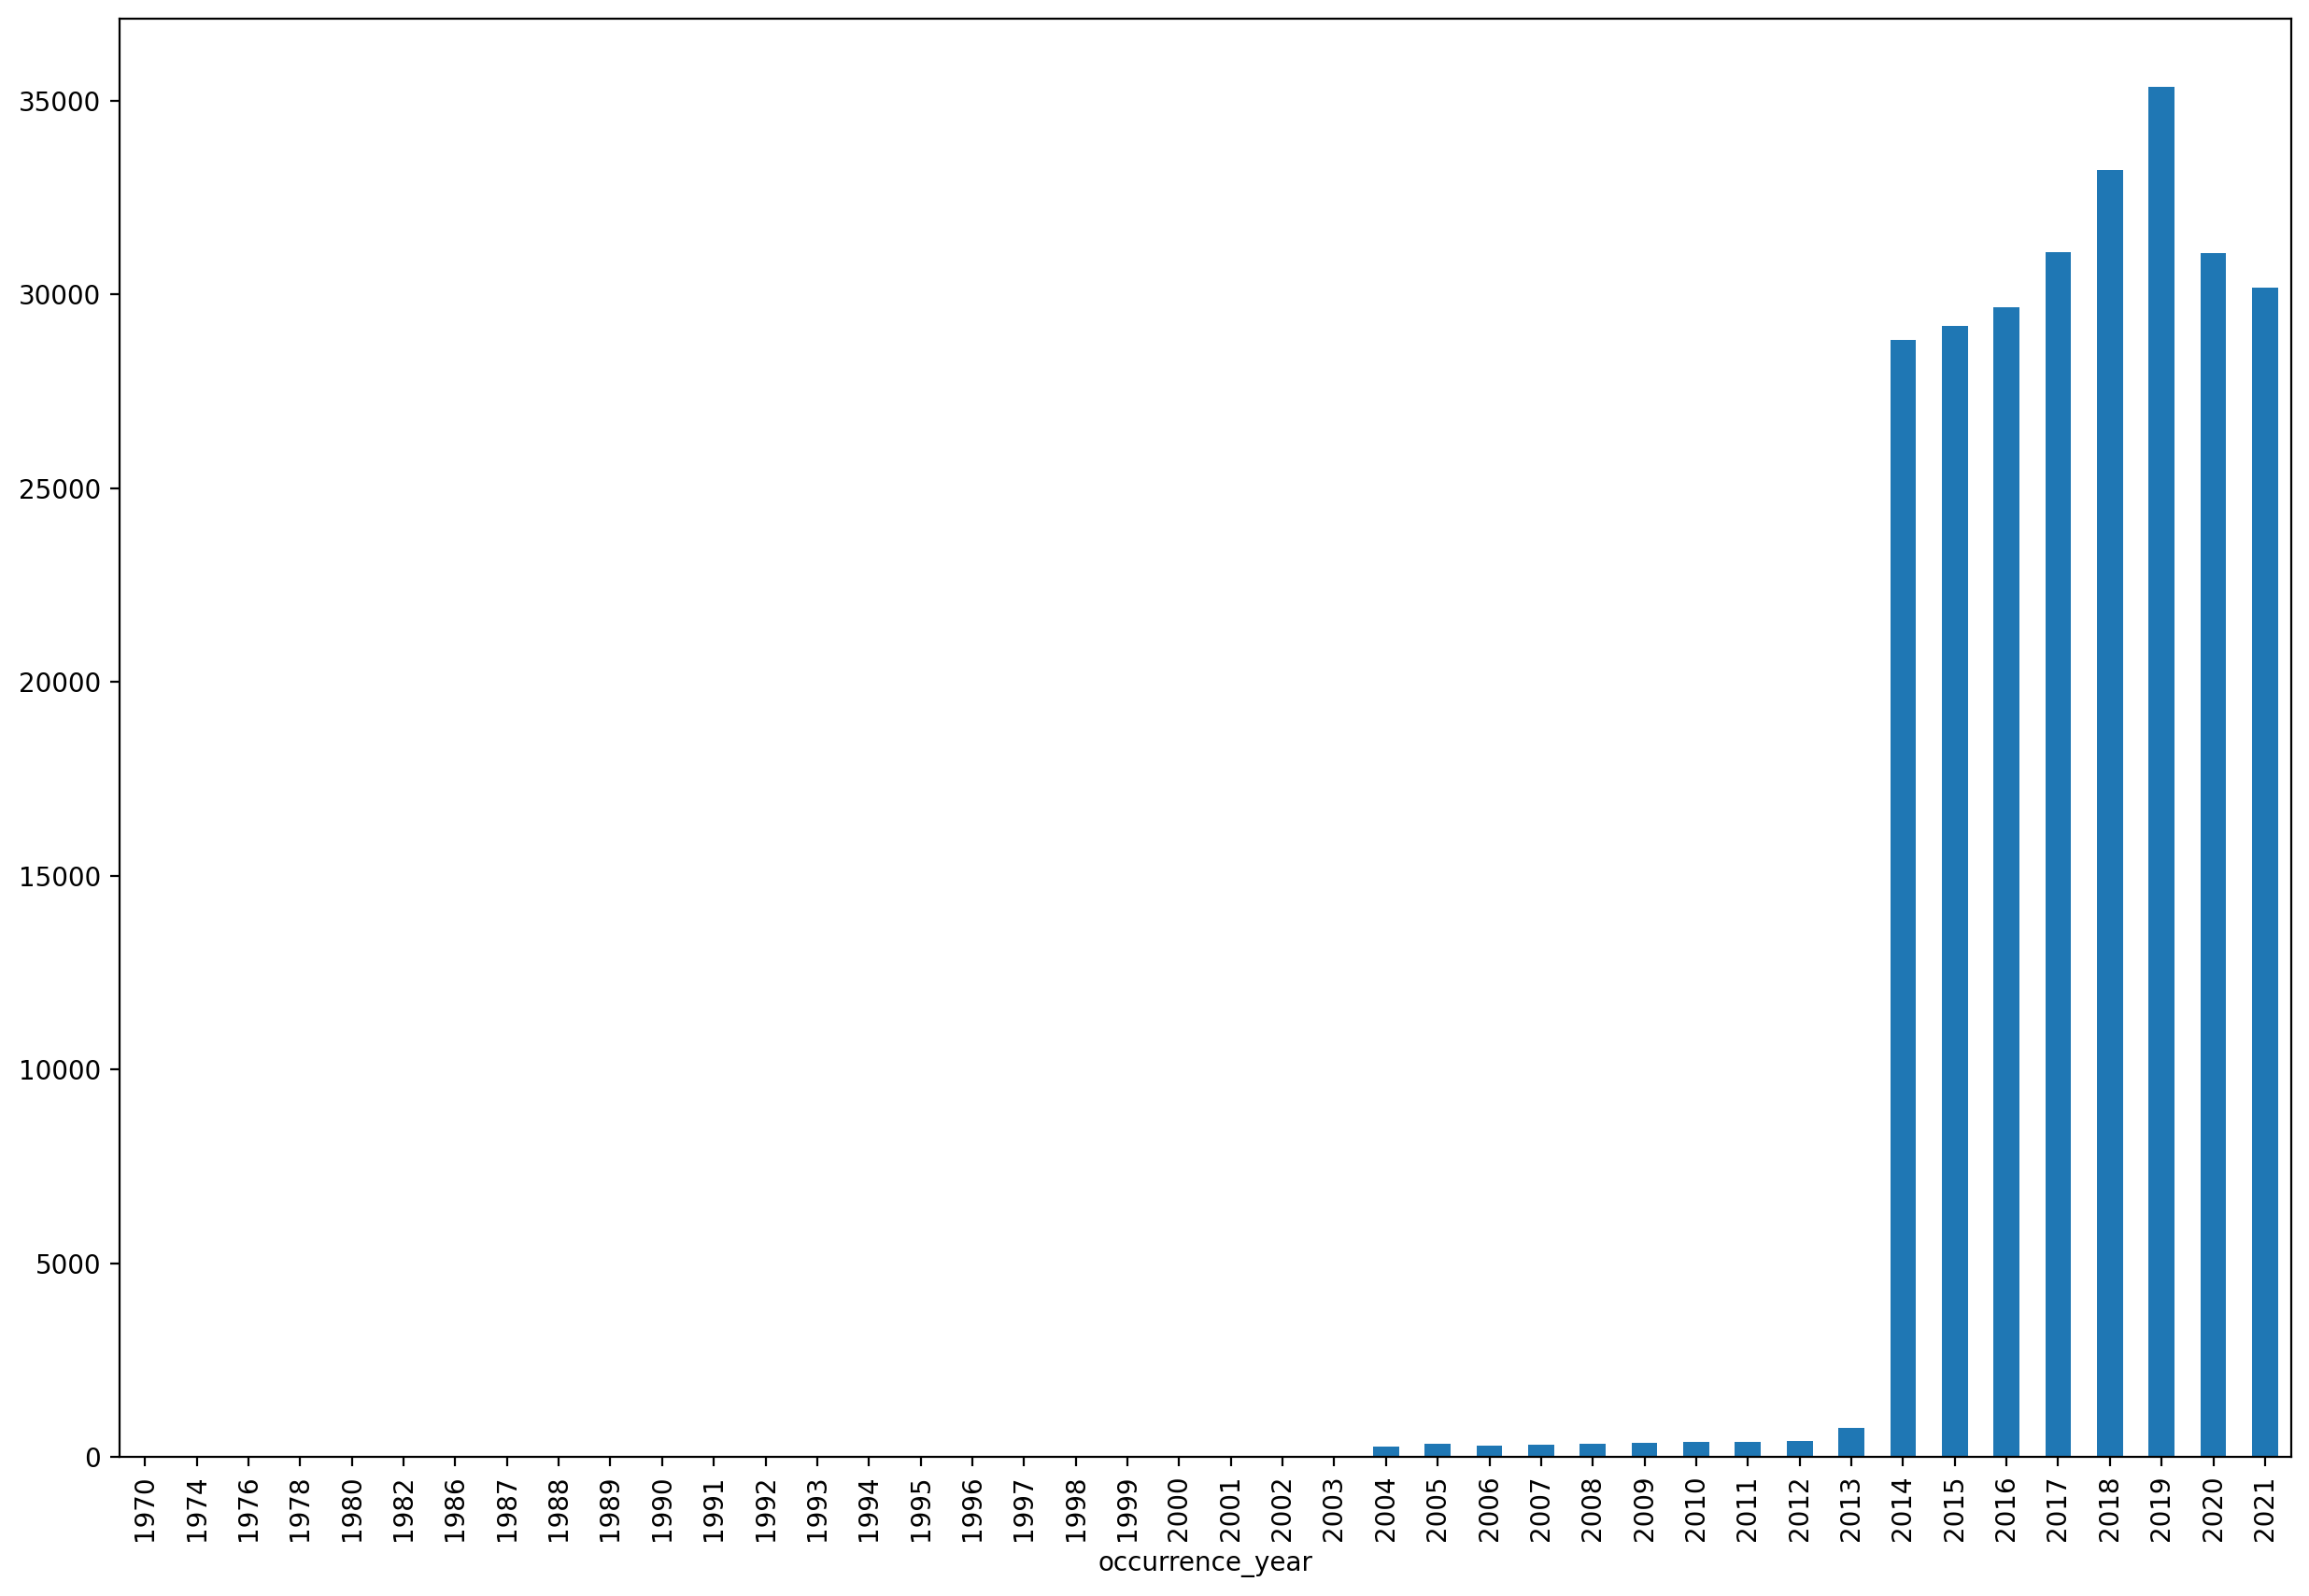

In [94]:
# There is limited data for crimes which happened before 2014
mci_point.groupby("occurrence_year").size().plot(kind="bar")

In [95]:
mci_select = mci_point[mci_point['occurrence_year'] >= 2014]

In [96]:
# output file to processed folder
# csv instead of geojson due to size
mci_select.to_csv('../data/processed/mci_select.csv', index=False)

# Aggregate crimes by quarter after 2014

In [97]:
# filter out data before 2014 and marked as NSA (outside City of Toronto)
mci_groupby = mci_select[mci_select.neighbourhood != "NSA"].groupby(["neighbourhood", "hood_id", "occurrence_year", "occurrence_quarter", "MCI"]).size()
# unstack to fill those neighbourhoods with no crime record with 0, e.g. homicide and shootings are rare
mci_groupby = mci_groupby.unstack(fill_value=0).stack().reset_index(name = 'count')
mci_groupby

neighbourhood hood_id  occurrence_year  occurrence_quarter  \
0         Agincourt North     129             2014                   1   
1         Agincourt North     129             2014                   1   
2         Agincourt North     129             2014                   1   
3         Agincourt North     129             2014                   1   
4         Agincourt North     129             2014                   1   
...                   ...     ...              ...                 ...   
31355  Yorkdale-Glen Park      31             2021                   4   
31356  Yorkdale-Glen Park      31             2021                   4   
31357  Yorkdale-Glen Park      31             2021                   4   
31358  Yorkdale-Glen Park      31             2021                   4   
31359  Yorkdale-Glen Park      31             2021                   4   

                   MCI  count  
0              Assault     15  
1           Auto Theft      4  
2      Break and Enter     11  
3             Homicide      0  
4              Robbery      9  
...                ...    ...  
31355  Break and Enter     14  
31356         Homicide      0  
31357          Robbery      7  
31358        Shootings      0  
31359       Theft Over      5  

[31360 rows x 6 columns]

In [98]:
mci_groupby.occurrence_year.unique()

array([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021], dtype=int64)

In [99]:
mci_groupby.MCI.unique()

array(['Assault', 'Auto Theft', 'Break and Enter', 'Homicide', 'Robbery',
       'Shootings', 'Theft Over'], dtype=object)

## add MCI aggregate

In [100]:
mci_types = ['Assault', 'Auto Theft', 'Break and Enter', 'Robbery', 'Theft Over']
mci_crime_all = mci_groupby[mci_groupby['MCI'].isin(mci_types)].groupby(['neighbourhood', 'hood_id', 'occurrence_year', 'occurrence_quarter'])[['count']].sum().reset_index()
mci_crime_all["MCI"] = "MCI"

In [101]:
mci_all = pd.concat([mci_groupby, mci_crime_all], axis=0)
mci_all

neighbourhood hood_id  occurrence_year  occurrence_quarter  \
0        Agincourt North     129             2014                   1   
1        Agincourt North     129             2014                   1   
2        Agincourt North     129             2014                   1   
3        Agincourt North     129             2014                   1   
4        Agincourt North     129             2014                   1   
...                  ...     ...              ...                 ...   
4475  Yorkdale-Glen Park      31             2020                   4   
4476  Yorkdale-Glen Park      31             2021                   1   
4477  Yorkdale-Glen Park      31             2021                   2   
4478  Yorkdale-Glen Park      31             2021                   3   
4479  Yorkdale-Glen Park      31             2021                   4   

                  MCI  count  
0             Assault     15  
1          Auto Theft      4  
2     Break and Enter     11  
3            Homicide      0  
4             Robbery      9  
...               ...    ...  
4475              MCI     85  
4476              MCI     51  
4477              MCI     54  
4478              MCI    103  
4479              MCI    101  

[35840 rows x 6 columns]

## add neighbourhood information

In [106]:
neighbourhoods_final = neighbourhoods[['hood_id', 'occurrence_year', 'area', 'population']]
neighbourhoods_final

hood_id  occurrence_year       area  population
0          1             2014  30.145103       34745
1          1             2015  30.145103       34557
2          1             2016  30.145103       34418
3          1             2017  30.145103       35085
4          1             2018  30.145103       35772
...      ...              ...        ...         ...
1255      99             2018   3.088880       17633
1256      99             2019   3.088880       17812
1257      99             2020   3.088880       17972
1258      99             2021   3.088880       18261
1259      99             2022   3.088880       18554

[1260 rows x 4 columns]

In [107]:
mci_all

neighbourhood hood_id  occurrence_year  occurrence_quarter  \
0        Agincourt North     129             2014                   1   
1        Agincourt North     129             2014                   1   
2        Agincourt North     129             2014                   1   
3        Agincourt North     129             2014                   1   
4        Agincourt North     129             2014                   1   
...                  ...     ...              ...                 ...   
4475  Yorkdale-Glen Park      31             2020                   4   
4476  Yorkdale-Glen Park      31             2021                   1   
4477  Yorkdale-Glen Park      31             2021                   2   
4478  Yorkdale-Glen Park      31             2021                   3   
4479  Yorkdale-Glen Park      31             2021                   4   

                  MCI  count  
0             Assault     15  
1          Auto Theft      4  
2     Break and Enter     11  
3            Homicide      0  
4             Robbery      9  
...               ...    ...  
4475              MCI     85  
4476              MCI     51  
4477              MCI     54  
4478              MCI    103  
4479              MCI    101  

[35840 rows x 6 columns]

In [108]:
neighbourhood_crime_merge = neighbourhoods_final.merge(mci_all, how='inner', on=['hood_id', 'occurrence_year'])
neighbourhood_crime_merge

hood_id  occurrence_year       area  population           neighbourhood  \
0           1             2014  30.145103       34745  West Humber-Clairville   
1           1             2014  30.145103       34745  West Humber-Clairville   
2           1             2014  30.145103       34745  West Humber-Clairville   
3           1             2014  30.145103       34745  West Humber-Clairville   
4           1             2014  30.145103       34745  West Humber-Clairville   
...       ...              ...        ...         ...                     ...   
35835      99             2021   3.088880       18261     Mount Pleasant East   
35836      99             2021   3.088880       18261     Mount Pleasant East   
35837      99             2021   3.088880       18261     Mount Pleasant East   
35838      99             2021   3.088880       18261     Mount Pleasant East   
35839      99             2021   3.088880       18261     Mount Pleasant East   

       occurrence_quarter              MCI  count  
0                       1          Assault     45  
1                       1       Auto Theft     64  
2                       1  Break and Enter     41  
3                       1         Homicide      0  
4                       1          Robbery     10  
...                   ...              ...    ...  
35835                   4       Theft Over      0  
35836                   1              MCI     20  
35837                   2              MCI     32  
35838                   3              MCI     27  
35839                   4              MCI     29  

[35840 rows x 8 columns]

In [109]:
neighbourhood_crime_merge.isna().sum()

hood_id               0
occurrence_year       0
area                  0
population            0
neighbourhood         0
occurrence_quarter    0
MCI                   0
count                 0
dtype: int64

## add rate / density

In [110]:
# rate: number of crimes per 100k people
neighbourhood_crime_merge['rate'] = neighbourhood_crime_merge['count'] / neighbourhood_crime_merge['population'] * 10**5
# density: number of crimes per 1km^2
neighbourhood_crime_merge['density'] = neighbourhood_crime_merge['count'] / neighbourhood_crime_merge['area']

In [111]:
neighbourhood_crime_merge

hood_id  occurrence_year       area  population           neighbourhood  \
0           1             2014  30.145103       34745  West Humber-Clairville   
1           1             2014  30.145103       34745  West Humber-Clairville   
2           1             2014  30.145103       34745  West Humber-Clairville   
3           1             2014  30.145103       34745  West Humber-Clairville   
4           1             2014  30.145103       34745  West Humber-Clairville   
...       ...              ...        ...         ...                     ...   
35835      99             2021   3.088880       18261     Mount Pleasant East   
35836      99             2021   3.088880       18261     Mount Pleasant East   
35837      99             2021   3.088880       18261     Mount Pleasant East   
35838      99             2021   3.088880       18261     Mount Pleasant East   
35839      99             2021   3.088880       18261     Mount Pleasant East   

       occurrence_quarter              MCI  count        rate    density  
0                       1          Assault     45  129.515038   1.492780  
1                       1       Auto Theft     64  184.199165   2.123065  
2                       1  Break and Enter     41  118.002590   1.360088  
3                       1         Homicide      0    0.000000   0.000000  
4                       1          Robbery     10   28.781120   0.331729  
...                   ...              ...    ...         ...        ...  
35835                   4       Theft Over      0    0.000000   0.000000  
35836                   1              MCI     20  109.523027   6.474839  
35837                   2              MCI     32  175.236844  10.359742  
35838                   3              MCI     27  147.856087   8.741033  
35839                   4              MCI     29  158.808389   9.388516  

[35840 rows x 10 columns]

In [112]:
neighbourhood_crime_melt = neighbourhood_crime_merge.melt(id_vars=['neighbourhood', 'hood_id', 'occurrence_year', 'occurrence_quarter', 'area', 'population', 'MCI'],
                                                           value_vars=['count', 'rate', 'density'],
                                                           var_name='type',
                                                           value_name='value')
neighbourhood_crime_melt

neighbourhood hood_id  occurrence_year  occurrence_quarter  \
0       West Humber-Clairville       1             2014                   1   
1       West Humber-Clairville       1             2014                   1   
2       West Humber-Clairville       1             2014                   1   
3       West Humber-Clairville       1             2014                   1   
4       West Humber-Clairville       1             2014                   1   
...                        ...     ...              ...                 ...   
107515     Mount Pleasant East      99             2021                   4   
107516     Mount Pleasant East      99             2021                   1   
107517     Mount Pleasant East      99             2021                   2   
107518     Mount Pleasant East      99             2021                   3   
107519     Mount Pleasant East      99             2021                   4   

             area  population              MCI     type      value  
0       30.145103       34745          Assault    count  45.000000  
1       30.145103       34745       Auto Theft    count  64.000000  
2       30.145103       34745  Break and Enter    count  41.000000  
3       30.145103       34745         Homicide    count   0.000000  
4       30.145103       34745          Robbery    count  10.000000  
...           ...         ...              ...      ...        ...  
107515   3.088880       18261       Theft Over  density   0.000000  
107516   3.088880       18261              MCI  density   6.474839  
107517   3.088880       18261              MCI  density  10.359742  
107518   3.088880       18261              MCI  density   8.741033  
107519   3.088880       18261              MCI  density   9.388516  

[107520 rows x 9 columns]

In [270]:
neighbourhood_crime_melt.to_csv('../data/processed/neighbourhoods_crime.csv', index=False)